In [1]:
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, Embedding
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
path_log_base = './logs'

In [4]:
def metrics(Y_validation,predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    num_classes = len(set(Y_validation))
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [5]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        #plt.ylim(0.50, 1)
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.eps', format='eps')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.svg', format='svg')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.pdf', format='pdf') 
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.png', format='png')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        #plt.ylim(0, 10)
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.eps', format='eps')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.svg', format='svg')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.pdf', format='pdf')
        #plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.png', format='png') 
        plt.show() 

In [6]:
def Final_Results_Test(PATH_trained_models, X_test, Y_test):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, Y_test,verbose=0)
            print(f'Loss={loss:.4f} and F1-score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [7]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [8]:
# Implementing DeepTE published by Yan et al. (2020)
def DeepTE(input_shape):
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(input_shape,1), name="input_1")
    #layer 1
    layers = tf.keras.layers.Conv1D(100, kernel_size=3, strides = 1, activation='relu')(inputs)
    layers = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(layers)
    #layer 2
    layers = tf.keras.layers.Conv1D(150, kernel_size=3, strides = 1, activation='relu')(layers)
    layers = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(layers)
    #layer 3
    layers = tf.keras.layers.Conv1D(225, kernel_size=3, strides = 1, activation='relu')(layers)
    layers = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128,activation="relu")(layers)    
    # layer 4
    layers = tf.keras.layers.Dropout(0.5)(layers)
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=f1_m)
    return model

# Using Complementary scheme

In [9]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.complementary'
training_data = pd.read_csv(filename)

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values
training_data = None

# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)
feature_vectors= None

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

feature_vectors_scaler = None
X_test_dev = None
Y_test_dev = None

# dimensional reduction with PCA
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

X_dev = None
X_test = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2094, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2092, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 697, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 695, 150)          45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 231, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 229, 225)          101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 76, 225)           0     

18/18 [==============================] - 1s 30ms/step - loss: 0.4304 - f1_m: 0.8448 - val_loss: 3.3077 - val_f1_m: 0.3896
Epoch 49/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3995 - f1_m: 0.8459 - val_loss: 3.2782 - val_f1_m: 0.3857
Epoch 50/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3932 - f1_m: 0.8539 - val_loss: 3.3707 - val_f1_m: 0.3880
Epoch 51/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3667 - f1_m: 0.8598 - val_loss: 3.6454 - val_f1_m: 0.3789
Epoch 52/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3657 - f1_m: 0.8625 - val_loss: 3.2182 - val_f1_m: 0.4117
Epoch 53/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3595 - f1_m: 0.8557 - val_loss: 3.6241 - val_f1_m: 0.3849
Epoch 54/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3894 - f1_m: 0.8551 - val_loss: 3.8640 - val_f1_m: 0.3966
Epoch 55/200
18/18 [==============================] - 1s 30ms/step -

Epoch 109/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2362 - f1_m: 0.9128 - val_loss: 5.6198 - val_f1_m: 0.3816
Epoch 110/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2654 - f1_m: 0.8984 - val_loss: 5.6613 - val_f1_m: 0.3923
Epoch 111/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2347 - f1_m: 0.9100 - val_loss: 5.7203 - val_f1_m: 0.4034
Epoch 112/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2525 - f1_m: 0.9023 - val_loss: 5.3278 - val_f1_m: 0.3758
Epoch 113/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2651 - f1_m: 0.9009 - val_loss: 5.4826 - val_f1_m: 0.4074
Epoch 114/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2477 - f1_m: 0.9043 - val_loss: 5.8896 - val_f1_m: 0.3810
Epoch 115/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2463 - f1_m: 0.9028 - val_loss: 5.5746 - val_f1_m: 0.3852
Epoch 116/200
18/18 [===========================

18/18 [==============================] - 1s 30ms/step - loss: 0.2191 - f1_m: 0.9155 - val_loss: 7.2027 - val_f1_m: 0.3819
Epoch 170/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2134 - f1_m: 0.9151 - val_loss: 6.6827 - val_f1_m: 0.3836
Epoch 171/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1980 - f1_m: 0.9248 - val_loss: 7.3330 - val_f1_m: 0.3763
Epoch 172/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1914 - f1_m: 0.9304 - val_loss: 7.0804 - val_f1_m: 0.3879
Epoch 173/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1983 - f1_m: 0.9257 - val_loss: 6.6051 - val_f1_m: 0.3999
Epoch 174/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2147 - f1_m: 0.9186 - val_loss: 7.2744 - val_f1_m: 0.3886
Epoch 175/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1773 - f1_m: 0.9311 - val_loss: 7.7132 - val_f1_m: 0.3763
Epoch 176/200
18/18 [==============================] - 1s 30ms

Loss=4.4139 and F1-score=0.4087

saved-model-064-0.4145.hdf5
Loss=4.3417 and F1-score=0.4151

saved-model-065-0.3986.hdf5
Loss=4.1980 and F1-score=0.4068

saved-model-066-0.3942.hdf5
Loss=4.3476 and F1-score=0.4050

saved-model-067-0.3919.hdf5
Loss=4.5978 and F1-score=0.4107

saved-model-068-0.3933.hdf5
Loss=4.8241 and F1-score=0.4020

saved-model-069-0.3836.hdf5
Loss=4.6553 and F1-score=0.4074

saved-model-070-0.3919.hdf5
Loss=4.4279 and F1-score=0.4126

saved-model-071-0.3880.hdf5
Loss=4.6518 and F1-score=0.3954

saved-model-072-0.4029.hdf5
Loss=4.5115 and F1-score=0.4116

saved-model-073-0.3919.hdf5
Loss=4.4023 and F1-score=0.4120

saved-model-074-0.3884.hdf5
Loss=4.9625 and F1-score=0.4075

saved-model-075-0.4048.hdf5
Loss=4.6867 and F1-score=0.4207

saved-model-076-0.3951.hdf5
Loss=5.0492 and F1-score=0.4150

saved-model-077-0.3791.hdf5
Loss=4.8711 and F1-score=0.4013

saved-model-078-0.3912.hdf5
Loss=4.9951 and F1-score=0.4094

saved-model-079-0.3924.hdf5
Loss=4.5831 and F1-score

Loss=8.0868 and F1-score=0.4061

saved-model-199-0.3879.hdf5
Loss=7.7109 and F1-score=0.4057

saved-model-200-0.3798.hdf5
Loss=7.5798 and F1-score=0.4090



Best
saved-model-095-0.4054.hdf5
Loss=4.9846 y Accuracy=0.4292



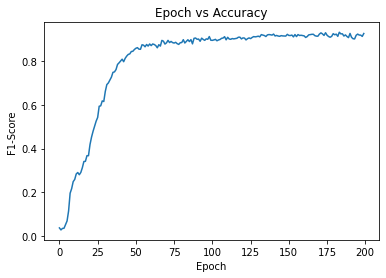

Test F1-Score 0.4292362332344055, Época:95

Test F1-Score 0.42261314392089844, Época:157

Test F1-Score 0.42066308856010437, Época:75

Test F1-Score 0.4200217127799988, Época:46

Test F1-Score 0.41624799370765686, Época:88

Test F1-Score 0.415979266166687, Época:166

Test F1-Score 0.4154406189918518, Época:85

Test F1-Score 0.4151041507720947, Época:64

Test F1-Score 0.41503894329071045, Época:76

Test F1-Score 0.4144774079322815, Época:44


Train F1-Score 0.9332488179206848, Época:184

Train F1-Score 0.9310743808746338, Época:175

Train F1-Score 0.9303876161575317, Época:172

Train F1-Score 0.9277580976486206, Época:191

Train F1-Score 0.927417516708374, Época:200

Train F1-Score 0.926630437374115, Época:180

Train F1-Score 0.9261834025382996, Época:186

Train F1-Score 0.9256917238235474, Época:185

Train F1-Score 0.9256532192230225, Época:173

Train F1-Score 0.9248517155647278, Época:141


Validation F1-Score 0.4198897182941437, Época:31

Validation F1-Score 0.41928550601005554, Époc

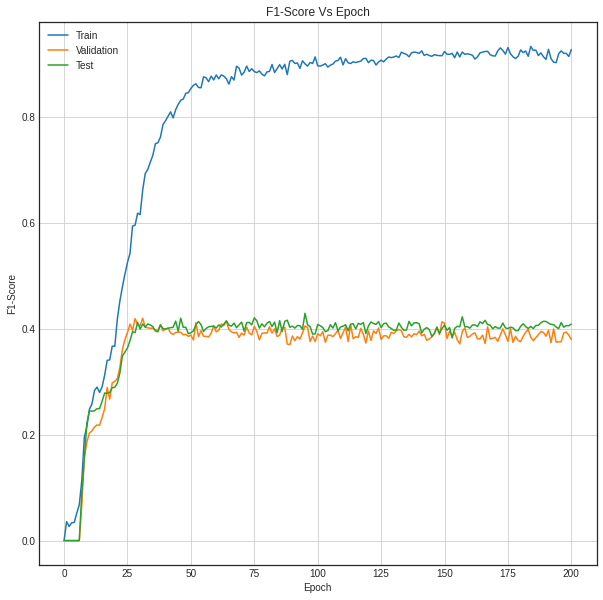

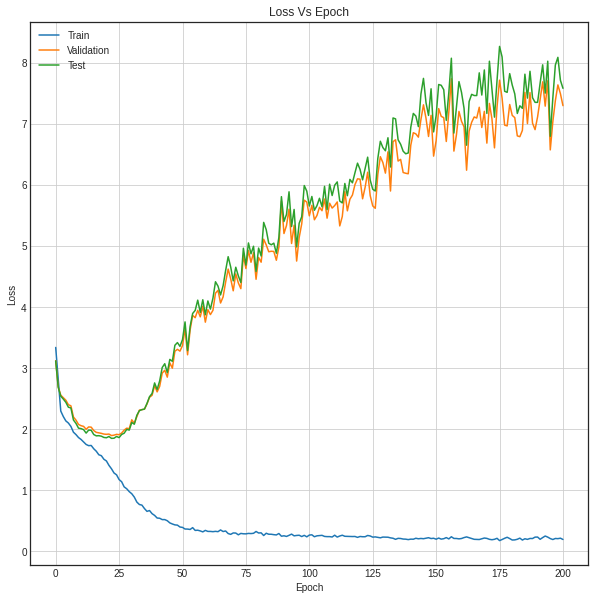

Baseline Error train: 0.07%
Baseline Error dev: 60.14%
Baseline Error test: 59.10%
Accuracy: 0.9995600527936648
F1 score: 0.9995604377651149
Recall: 0.9995600527936648
Precision: 0.9995627685171606

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       667
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        28
           9       1.00      1.00      1.00       372
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00       443
          18       1.00      1.00      1.00       133
          19       1.00      1.00      1.00        82
          20       0.99      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       

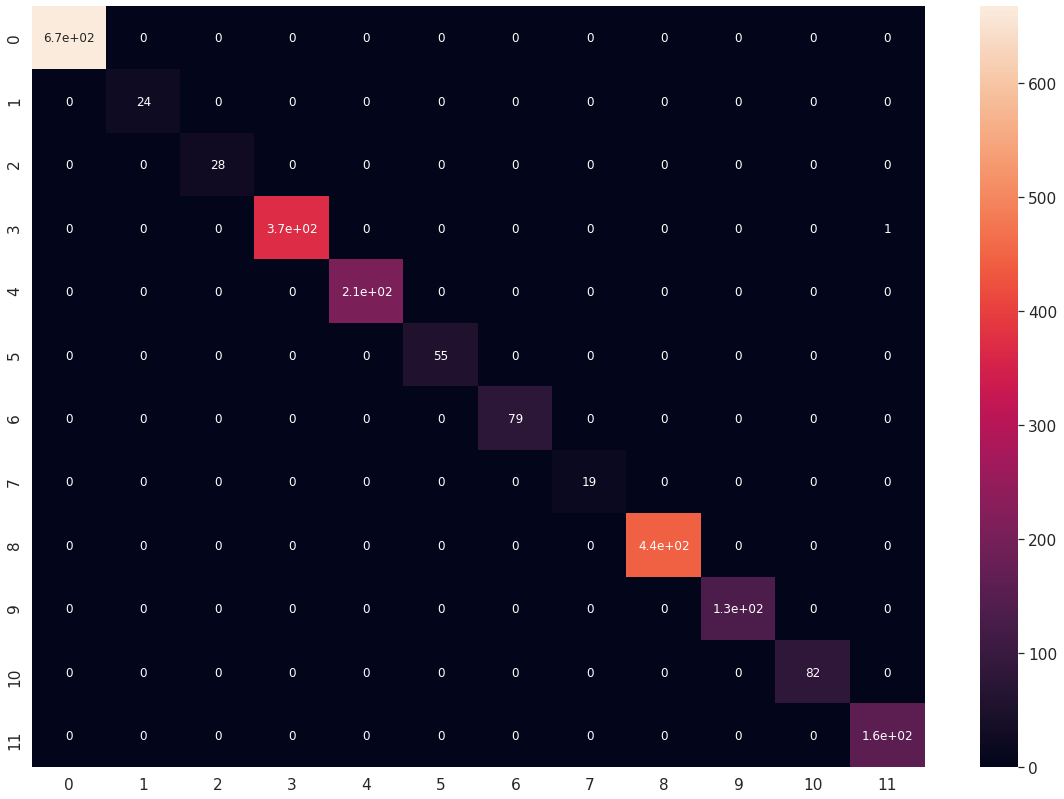

Accuracy: 0.39436619718309857
F1 score: 0.2986522572954625
Recall: 0.39436619718309857
Precision: 0.25328087360115403

 clasification report:
               precision    recall  f1-score   support

           1       0.57      0.80      0.66        88
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           9       0.29      0.91      0.44        34
          12       0.00      0.00      0.00        34
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         3
          17       0.25      0.23      0.24        48
          18       0.00      0.00      0.00        15
          19       0.00      0.00      0.00        17
          20       0.00      0.00      0.00        20

    accuracy                           0.39       284
   macro avg       0.09      0.16      0.11       284
weighted avg       0.25      0.39      0.30  

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


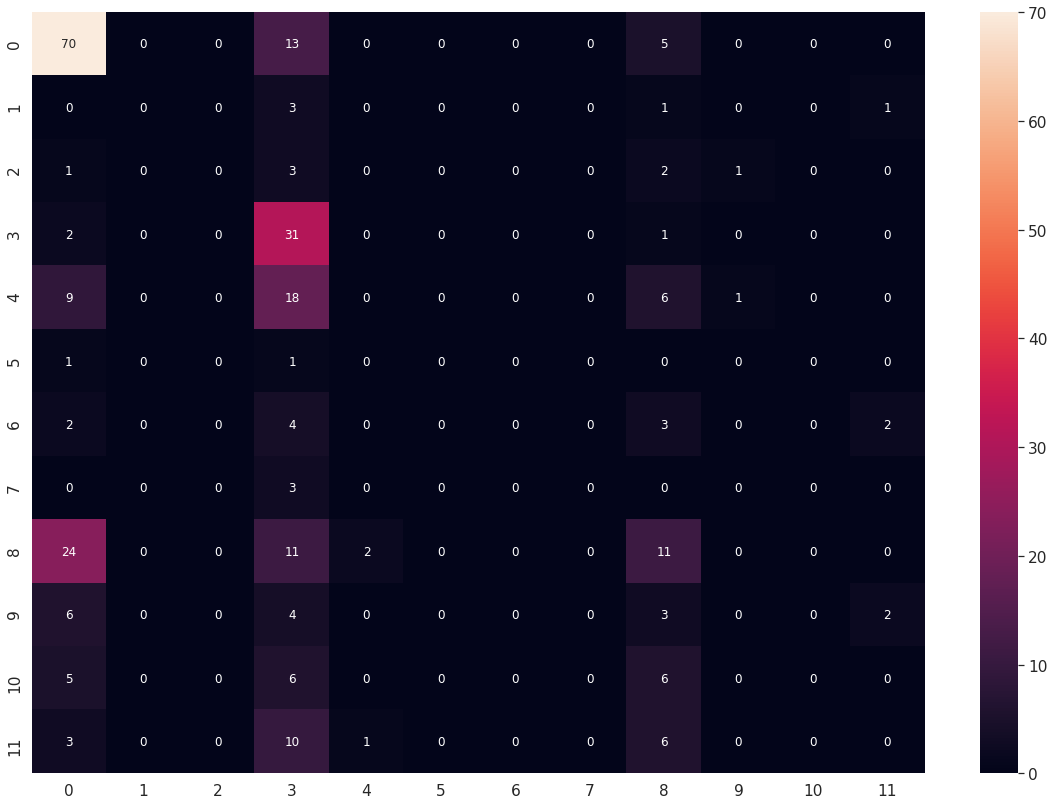

Accuracy: 0.40350877192982454
F1 score: 0.30235211027105996
Recall: 0.40350877192982454
Precision: 0.33931011102635816

 clasification report:
               precision    recall  f1-score   support

           1       0.49      0.84      0.62        79
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           9       0.32      0.95      0.48        39
          12       0.33      0.05      0.09        37
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         5
          17       0.33      0.12      0.17        60
          18       0.00      0.00      0.00        14
          19       0.00      0.00      0.00         8
          20       0.60      0.14      0.22        22

    accuracy                           0.40       285
   macro avg       0.17      0.17      0.13       285
weighted avg       0.34      0.40      0.30 

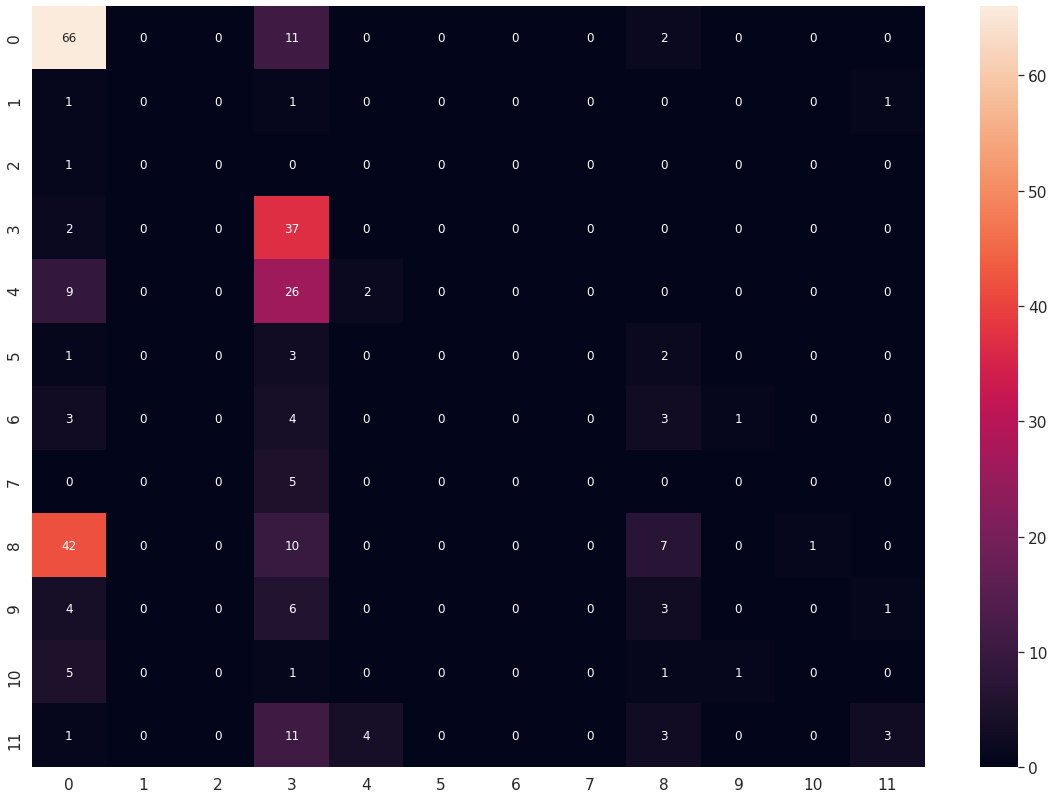

In [10]:
# baseline Nakano et al (2018) architecture 
model = DeepTE(X_trainPCAScaler.shape[1])
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# Using DAX complementary

In [11]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.DAX'
training_data = pd.read_csv(filename)

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values
training_data = None

# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)
feature_vectors= None

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

feature_vectors_scaler = None
X_test_dev = None
Y_test_dev = None

# dimensional reduction with PCA
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

X_dev = None
X_test = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2093, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2091, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 697, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 695, 150)          45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 231, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 229, 225)          101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 76, 225)           0     

18/18 [==============================] - 1s 30ms/step - loss: 0.5510 - f1_m: 0.7796 - val_loss: 3.2323 - val_f1_m: 0.3974
Epoch 47/200
18/18 [==============================] - 1s 29ms/step - loss: 0.5684 - f1_m: 0.7730 - val_loss: 3.2199 - val_f1_m: 0.4024
Epoch 48/200
18/18 [==============================] - 1s 30ms/step - loss: 0.5334 - f1_m: 0.7952 - val_loss: 3.6324 - val_f1_m: 0.3925
Epoch 49/200
18/18 [==============================] - 1s 30ms/step - loss: 0.5048 - f1_m: 0.7932 - val_loss: 3.7267 - val_f1_m: 0.3945
Epoch 50/200
18/18 [==============================] - 1s 30ms/step - loss: 0.4724 - f1_m: 0.8145 - val_loss: 3.6166 - val_f1_m: 0.3961
Epoch 51/200
18/18 [==============================] - 1s 30ms/step - loss: 0.4708 - f1_m: 0.8124 - val_loss: 3.6463 - val_f1_m: 0.3980
Epoch 52/200
18/18 [==============================] - 1s 30ms/step - loss: 0.4506 - f1_m: 0.8143 - val_loss: 3.7743 - val_f1_m: 0.3915
Epoch 53/200
18/18 [==============================] - 1s 30ms/step -

Epoch 107/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2778 - f1_m: 0.8855 - val_loss: 7.2704 - val_f1_m: 0.3954
Epoch 108/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2945 - f1_m: 0.8811 - val_loss: 7.1430 - val_f1_m: 0.3924
Epoch 109/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2626 - f1_m: 0.8974 - val_loss: 7.5859 - val_f1_m: 0.3810
Epoch 110/200
18/18 [==============================] - 1s 29ms/step - loss: 0.2492 - f1_m: 0.9035 - val_loss: 7.2814 - val_f1_m: 0.3976
Epoch 111/200
18/18 [==============================] - 1s 31ms/step - loss: 0.2663 - f1_m: 0.8914 - val_loss: 7.0168 - val_f1_m: 0.3870
Epoch 112/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2721 - f1_m: 0.8876 - val_loss: 7.1768 - val_f1_m: 0.3832
Epoch 113/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2693 - f1_m: 0.8875 - val_loss: 7.5634 - val_f1_m: 0.3837
Epoch 114/200
18/18 [===========================

18/18 [==============================] - 1s 30ms/step - loss: 0.2089 - f1_m: 0.9185 - val_loss: 9.8007 - val_f1_m: 0.3745
Epoch 168/200
18/18 [==============================] - 1s 29ms/step - loss: 0.2120 - f1_m: 0.9164 - val_loss: 9.9022 - val_f1_m: 0.3784
Epoch 169/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2335 - f1_m: 0.9099 - val_loss: 9.3068 - val_f1_m: 0.3950
Epoch 170/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2300 - f1_m: 0.9089 - val_loss: 9.4388 - val_f1_m: 0.3863
Epoch 171/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1979 - f1_m: 0.9220 - val_loss: 9.4417 - val_f1_m: 0.3825
Epoch 172/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2133 - f1_m: 0.9158 - val_loss: 9.8014 - val_f1_m: 0.3925
Epoch 173/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2387 - f1_m: 0.9052 - val_loss: 9.2316 - val_f1_m: 0.3792
Epoch 174/200
18/18 [==============================] - 1s 30ms

Loss=4.8559 and F1-score=0.3745

saved-model-059-0.3915.hdf5
Loss=4.8374 and F1-score=0.3753

saved-model-060-0.3990.hdf5
Loss=4.7690 and F1-score=0.3830

saved-model-061-0.3920.hdf5
Loss=4.9476 and F1-score=0.3788

saved-model-062-0.3897.hdf5
Loss=5.3930 and F1-score=0.3738

saved-model-063-0.3883.hdf5
Loss=5.2459 and F1-score=0.3722

saved-model-064-0.3869.hdf5
Loss=5.2312 and F1-score=0.3821

saved-model-065-0.3927.hdf5
Loss=5.4595 and F1-score=0.3751

saved-model-066-0.3883.hdf5
Loss=5.6397 and F1-score=0.3772

saved-model-067-0.3863.hdf5
Loss=5.5282 and F1-score=0.3804

saved-model-068-0.3852.hdf5
Loss=5.5962 and F1-score=0.3711

saved-model-069-0.3928.hdf5
Loss=5.5568 and F1-score=0.3790

saved-model-070-0.3892.hdf5
Loss=5.9959 and F1-score=0.3738

saved-model-071-0.3919.hdf5
Loss=5.9671 and F1-score=0.3758

saved-model-072-0.3937.hdf5
Loss=5.8952 and F1-score=0.3747

saved-model-073-0.3829.hdf5
Loss=5.9278 and F1-score=0.3699

saved-model-074-0.3892.hdf5
Loss=6.1445 and F1-score

Loss=11.5064 and F1-score=0.3754

saved-model-193-0.3827.hdf5
Loss=10.6832 and F1-score=0.3731

saved-model-194-0.3831.hdf5
Loss=11.2937 and F1-score=0.3720

saved-model-195-0.3985.hdf5
Loss=11.5166 and F1-score=0.3721

saved-model-196-0.3679.hdf5
Loss=10.7610 and F1-score=0.3713

saved-model-197-0.3853.hdf5
Loss=11.8253 and F1-score=0.3688

saved-model-198-0.3765.hdf5
Loss=11.2935 and F1-score=0.3619

saved-model-199-0.3834.hdf5
Loss=11.3492 and F1-score=0.3737

saved-model-200-0.3863.hdf5
Loss=11.1091 and F1-score=0.3680



Best
saved-model-041-0.4027.hdf5
Loss=3.1158 y Accuracy=0.3947



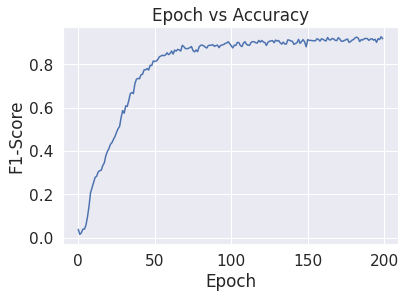

Test F1-Score 0.394726037979126, Época:41

Test F1-Score 0.39317435026168823, Época:47

Test F1-Score 0.3924679160118103, Época:45

Test F1-Score 0.39022016525268555, Época:39

Test F1-Score 0.3896177411079407, Época:44

Test F1-Score 0.3892536163330078, Época:46

Test F1-Score 0.38886040449142456, Época:50

Test F1-Score 0.3888356387615204, Época:38

Test F1-Score 0.38849011063575745, Época:42

Test F1-Score 0.38805854320526123, Época:34


Train F1-Score 0.9264471530914307, Época:199

Train F1-Score 0.9247579574584961, Época:183

Train F1-Score 0.9230445027351379, Época:164

Train F1-Score 0.9220033288002014, Época:171

Train F1-Score 0.9215010404586792, Época:182

Train F1-Score 0.9199211597442627, Época:184

Train F1-Score 0.9187476634979248, Época:189

Train F1-Score 0.9185168147087097, Época:167

Train F1-Score 0.9175385236740112, Época:190

Train F1-Score 0.9174783229827881, Época:193


Validation F1-Score 0.4066505432128906, Época:88

Validation F1-Score 0.40272629261016846, Épo

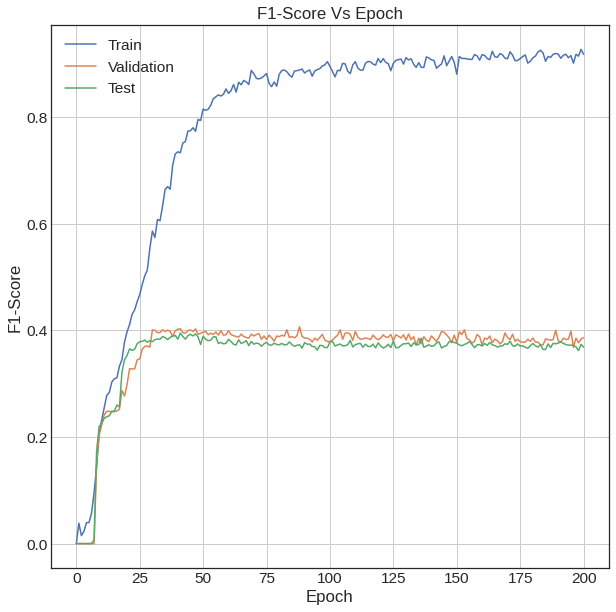

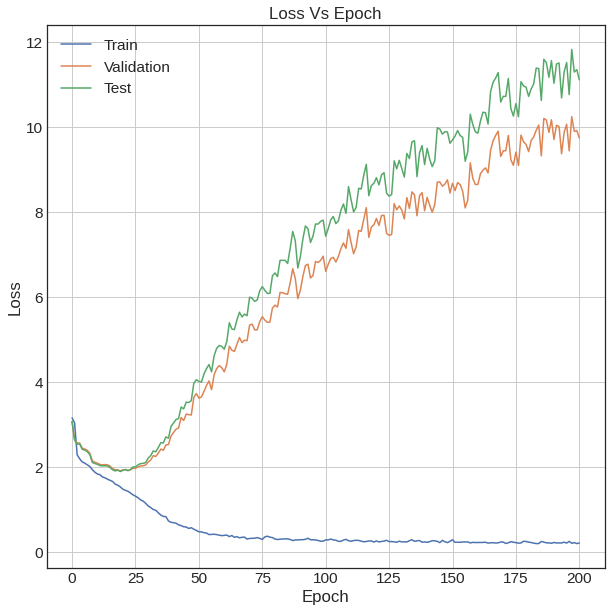

Baseline Error train: 0.09%
Baseline Error dev: 60.91%
Baseline Error test: 63.20%
Accuracy: 0.9991201055873296
F1 score: 0.9991183467893763
Recall: 0.9991201055873296
Precision: 0.9991240601689596

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       667
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        28
           9       1.00      1.00      1.00       372
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00       443
          18       1.00      1.00      1.00       133
          19       1.00      1.00      1.00        82
          20       1.00      0.99      0.99       161

    accuracy                           1.00      2273
   macro avg       

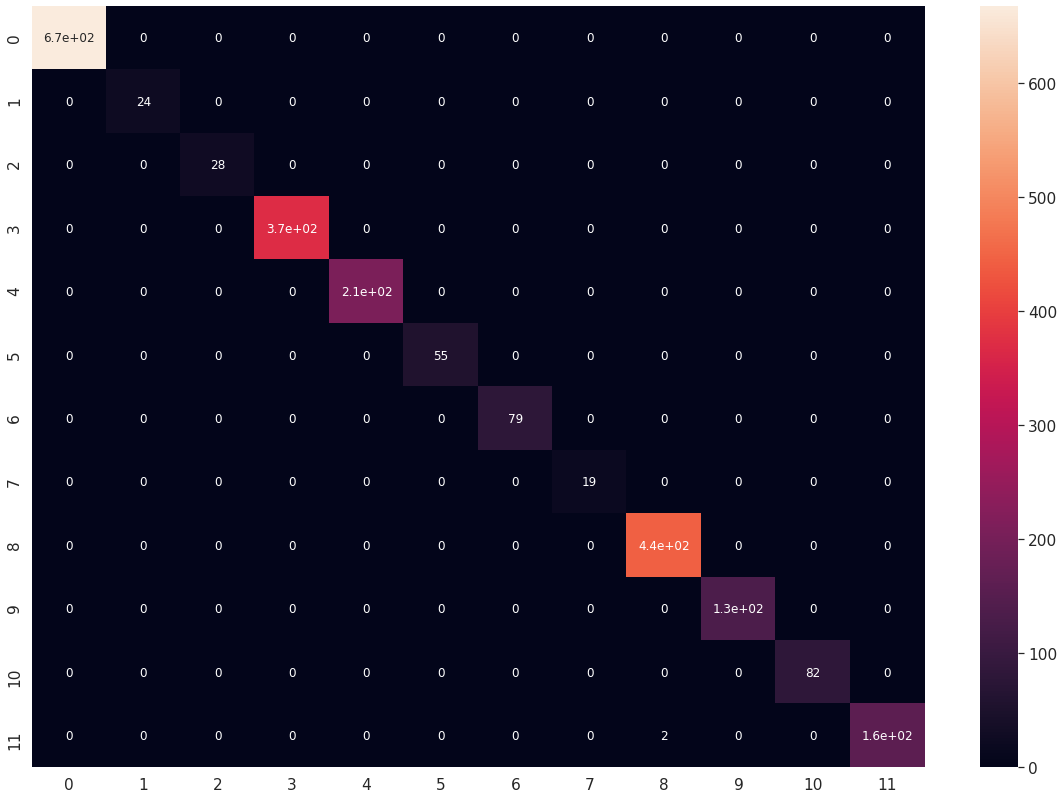

Accuracy: 0.38380281690140844
F1 score: 0.27643230172881766
Recall: 0.38380281690140844
Precision: 0.2665466483109181

 clasification report:
               precision    recall  f1-score   support

           1       0.50      0.80      0.61        88
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           9       0.29      0.97      0.45        34
          12       0.14      0.06      0.08        34
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00        48
          18       0.00      0.00      0.00        15
          19       1.00      0.24      0.38        17
          20       0.00      0.00      0.00        20

    accuracy                           0.38       284
   macro avg       0.16      0.17      0.13       284
weighted avg       0.27      0.38      0.28  

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


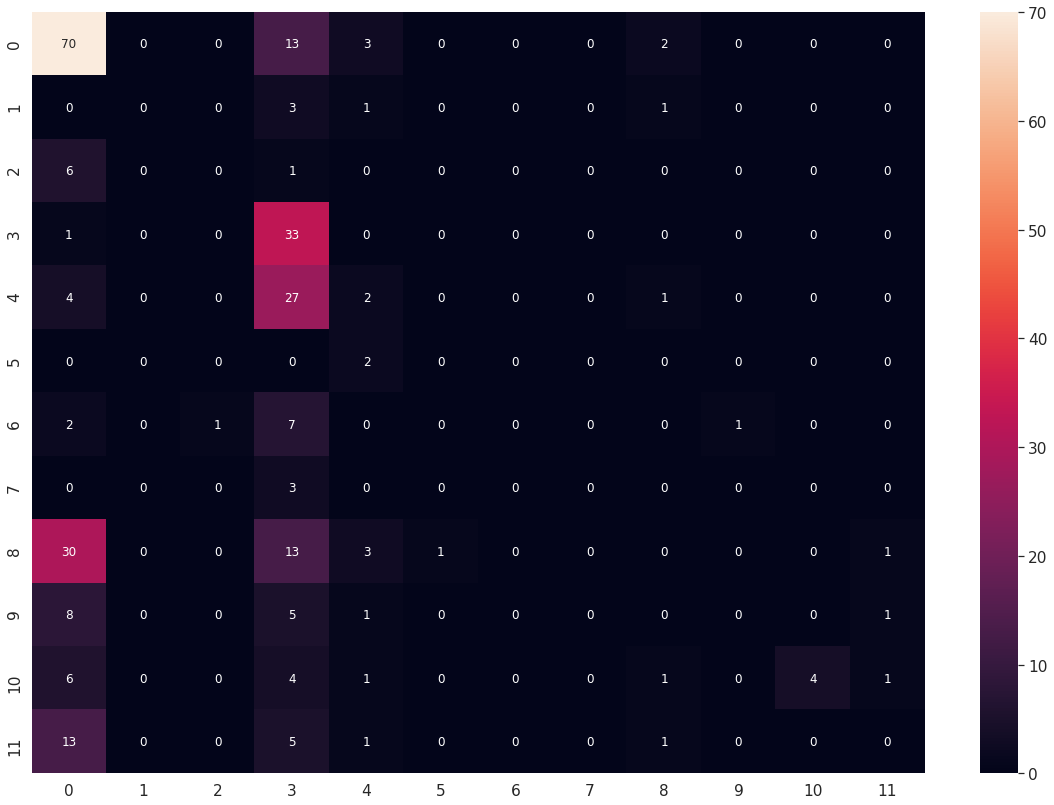

Accuracy: 0.36140350877192984
F1 score: 0.2336235266658887
Recall: 0.36140350877192984
Precision: 0.20511932313052134

 clasification report:
               precision    recall  f1-score   support

           1       0.48      0.85      0.61        79
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           9       0.28      0.90      0.43        39
          12       0.00      0.00      0.00        37
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         5
          17       0.17      0.02      0.03        60
          18       0.00      0.00      0.00        14
          19       0.00      0.00      0.00         8
          20       0.00      0.00      0.00        22

    accuracy                           0.36       285
   macro avg       0.08      0.15      0.09       285
weighted avg       0.21      0.36      0.23  

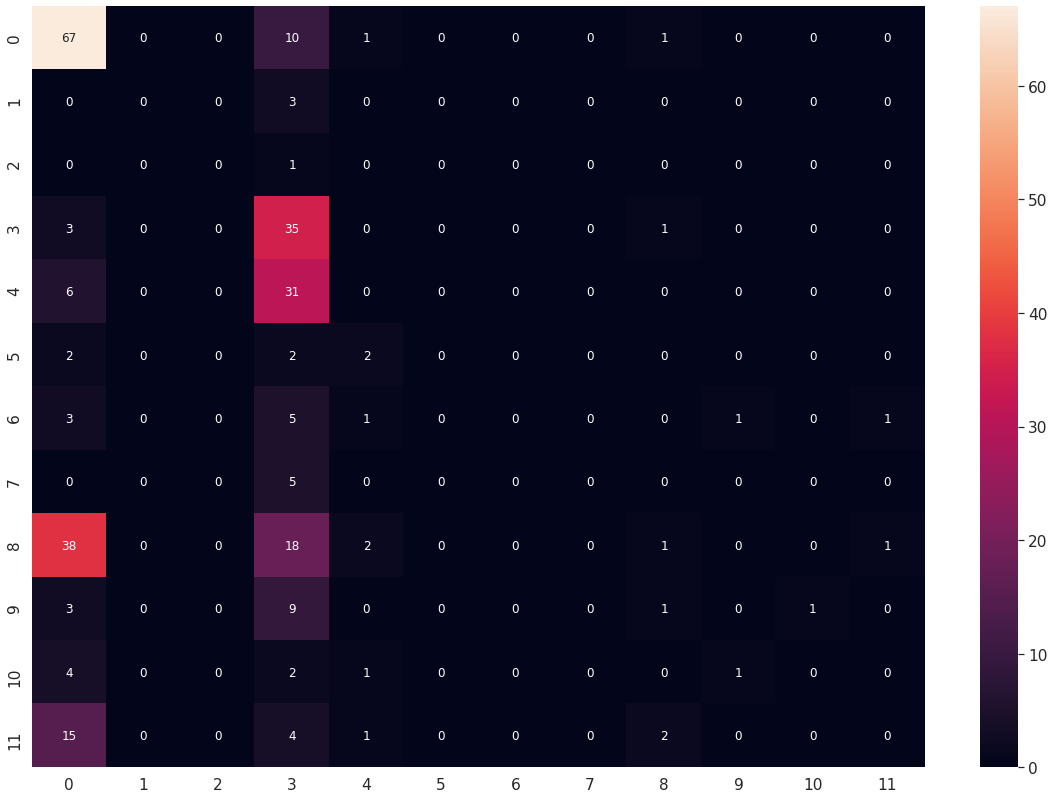

In [12]:
# baseline Nakano et al (2018) architecture 
model = DeepTE(X_trainPCAScaler.shape[1])
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# Using EIIP coding scheme

In [13]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.DAX'
training_data = pd.read_csv(filename)

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values
training_data = None

# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)
feature_vectors= None

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

feature_vectors_scaler = None
X_test_dev = None
Y_test_dev = None

# dimensional reduction with PCA
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

X_dev = None
X_test = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2093, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2091, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 697, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 695, 150)          45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 231, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 229, 225)          101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 76, 225)           0     

18/18 [==============================] - 1s 30ms/step - loss: 0.2984 - f1_m: 0.8896 - val_loss: 4.7020 - val_f1_m: 0.4155
Epoch 47/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2746 - f1_m: 0.8958 - val_loss: 4.9402 - val_f1_m: 0.4160
Epoch 48/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2591 - f1_m: 0.9023 - val_loss: 4.9957 - val_f1_m: 0.4138
Epoch 49/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2659 - f1_m: 0.9030 - val_loss: 4.7475 - val_f1_m: 0.4103
Epoch 50/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2617 - f1_m: 0.9026 - val_loss: 5.1800 - val_f1_m: 0.4171
Epoch 51/200
18/18 [==============================] - 1s 31ms/step - loss: 0.2367 - f1_m: 0.9123 - val_loss: 4.9969 - val_f1_m: 0.4025
Epoch 52/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2441 - f1_m: 0.9130 - val_loss: 4.8963 - val_f1_m: 0.4171
Epoch 53/200
18/18 [==============================] - 1s 30ms/step -

Epoch 107/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1266 - f1_m: 0.9512 - val_loss: 8.5600 - val_f1_m: 0.3979
Epoch 108/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1392 - f1_m: 0.9471 - val_loss: 7.7108 - val_f1_m: 0.4067
Epoch 109/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1462 - f1_m: 0.9459 - val_loss: 7.9473 - val_f1_m: 0.4101
Epoch 110/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1257 - f1_m: 0.9499 - val_loss: 8.4092 - val_f1_m: 0.4154
Epoch 111/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1212 - f1_m: 0.9613 - val_loss: 7.9659 - val_f1_m: 0.4181
Epoch 112/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1402 - f1_m: 0.9514 - val_loss: 7.8351 - val_f1_m: 0.4133
Epoch 113/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1463 - f1_m: 0.9455 - val_loss: 7.8504 - val_f1_m: 0.4122
Epoch 114/200
18/18 [===========================

18/18 [==============================] - 1s 30ms/step - loss: 0.1074 - f1_m: 0.9590 - val_loss: 9.5626 - val_f1_m: 0.4091
Epoch 168/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1186 - f1_m: 0.9563 - val_loss: 9.7693 - val_f1_m: 0.4069
Epoch 169/200
18/18 [==============================] - 1s 31ms/step - loss: 0.1088 - f1_m: 0.9590 - val_loss: 9.2576 - val_f1_m: 0.4095
Epoch 170/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1226 - f1_m: 0.9545 - val_loss: 9.5229 - val_f1_m: 0.4069
Epoch 171/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1106 - f1_m: 0.9594 - val_loss: 9.8197 - val_f1_m: 0.3946
Epoch 172/200
18/18 [==============================] - 1s 31ms/step - loss: 0.1182 - f1_m: 0.9508 - val_loss: 9.0046 - val_f1_m: 0.4062
Epoch 173/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1188 - f1_m: 0.9543 - val_loss: 9.3406 - val_f1_m: 0.4121
Epoch 174/200
18/18 [==============================] - 1s 30ms

Loss=6.1796 and F1-score=0.3884

saved-model-059-0.3992.hdf5
Loss=6.3712 and F1-score=0.3875

saved-model-060-0.4110.hdf5
Loss=7.0512 and F1-score=0.3832

saved-model-061-0.4077.hdf5
Loss=6.4829 and F1-score=0.3866

saved-model-062-0.4014.hdf5
Loss=6.6314 and F1-score=0.3864

saved-model-063-0.3964.hdf5
Loss=6.5829 and F1-score=0.3811

saved-model-064-0.4116.hdf5
Loss=6.9426 and F1-score=0.3852

saved-model-065-0.4143.hdf5
Loss=6.9508 and F1-score=0.3852

saved-model-066-0.4176.hdf5
Loss=7.6177 and F1-score=0.3847

saved-model-067-0.4080.hdf5
Loss=7.1209 and F1-score=0.3923

saved-model-068-0.4099.hdf5
Loss=6.8681 and F1-score=0.3890

saved-model-069-0.4094.hdf5
Loss=7.6936 and F1-score=0.3829

saved-model-070-0.4031.hdf5
Loss=7.3611 and F1-score=0.3890

saved-model-071-0.4130.hdf5
Loss=7.2176 and F1-score=0.3798

saved-model-072-0.4149.hdf5
Loss=7.7404 and F1-score=0.3908

saved-model-073-0.4068.hdf5
Loss=8.0249 and F1-score=0.3762

saved-model-074-0.3970.hdf5
Loss=8.0145 and F1-score

Loss=10.9904 and F1-score=0.3833

saved-model-193-0.4037.hdf5
Loss=11.4033 and F1-score=0.3881

saved-model-194-0.4057.hdf5
Loss=11.7443 and F1-score=0.3918

saved-model-195-0.4021.hdf5
Loss=12.4144 and F1-score=0.3819

saved-model-196-0.4031.hdf5
Loss=11.7026 and F1-score=0.3913

saved-model-197-0.3963.hdf5
Loss=11.3176 and F1-score=0.3825

saved-model-198-0.4011.hdf5
Loss=11.8812 and F1-score=0.3866

saved-model-199-0.3984.hdf5
Loss=11.5478 and F1-score=0.3877

saved-model-200-0.4020.hdf5
Loss=11.6347 and F1-score=0.3783



Best
saved-model-026-0.4162.hdf5
Loss=2.4958 y Accuracy=0.3968



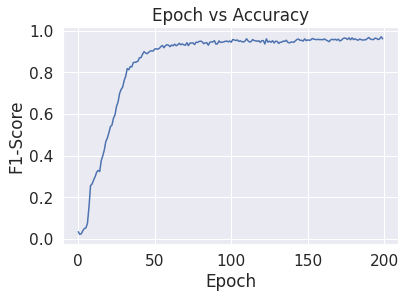

Test F1-Score 0.3967917263507843, Época:26

Test F1-Score 0.39539340138435364, Época:27

Test F1-Score 0.39539337158203125, Época:29

Test F1-Score 0.3944946527481079, Época:89

Test F1-Score 0.39403632283210754, Época:43

Test F1-Score 0.3934086263179779, Época:30

Test F1-Score 0.39336979389190674, Época:119

Test F1-Score 0.3933029770851135, Época:112

Test F1-Score 0.3929769694805145, Época:28

Test F1-Score 0.3929489552974701, Época:82


Train F1-Score 0.9710192084312439, Época:199

Train F1-Score 0.9673640727996826, Época:191

Train F1-Score 0.9657809734344482, Época:180

Train F1-Score 0.9657764434814453, Época:178

Train F1-Score 0.9648002982139587, Época:175

Train F1-Score 0.9643303751945496, Época:195

Train F1-Score 0.9633543491363525, Época:176

Train F1-Score 0.9626857042312622, Época:154

Train F1-Score 0.9626691341400146, Época:196

Train F1-Score 0.96260666847229, Época:190


Validation F1-Score 0.42596518993377686, Época:27

Validation F1-Score 0.4246465265750885, Épo

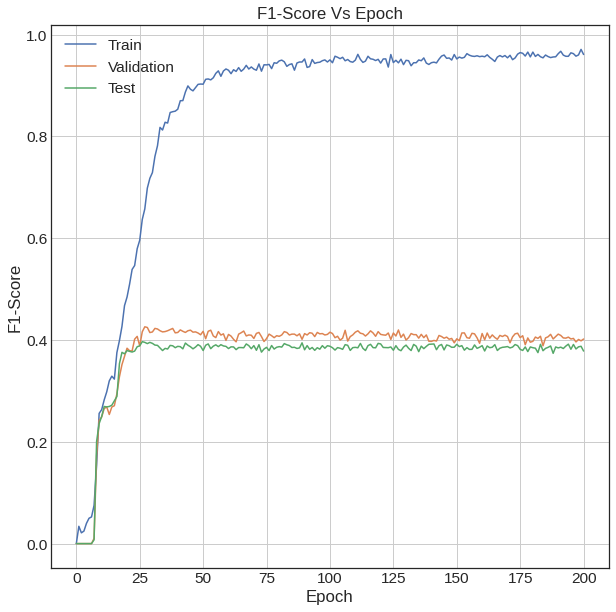

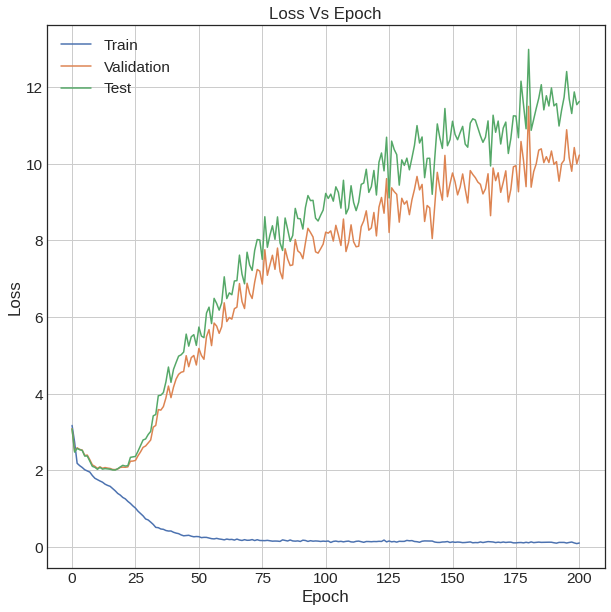

Baseline Error train: 0.00%
Baseline Error dev: 61.00%
Baseline Error test: 62.17%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       667
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        28
           9       1.00      1.00      1.00       372
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00       443
          18       1.00      1.00      1.00       133
          19       1.00      1.00      1.00        82
          20       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00  

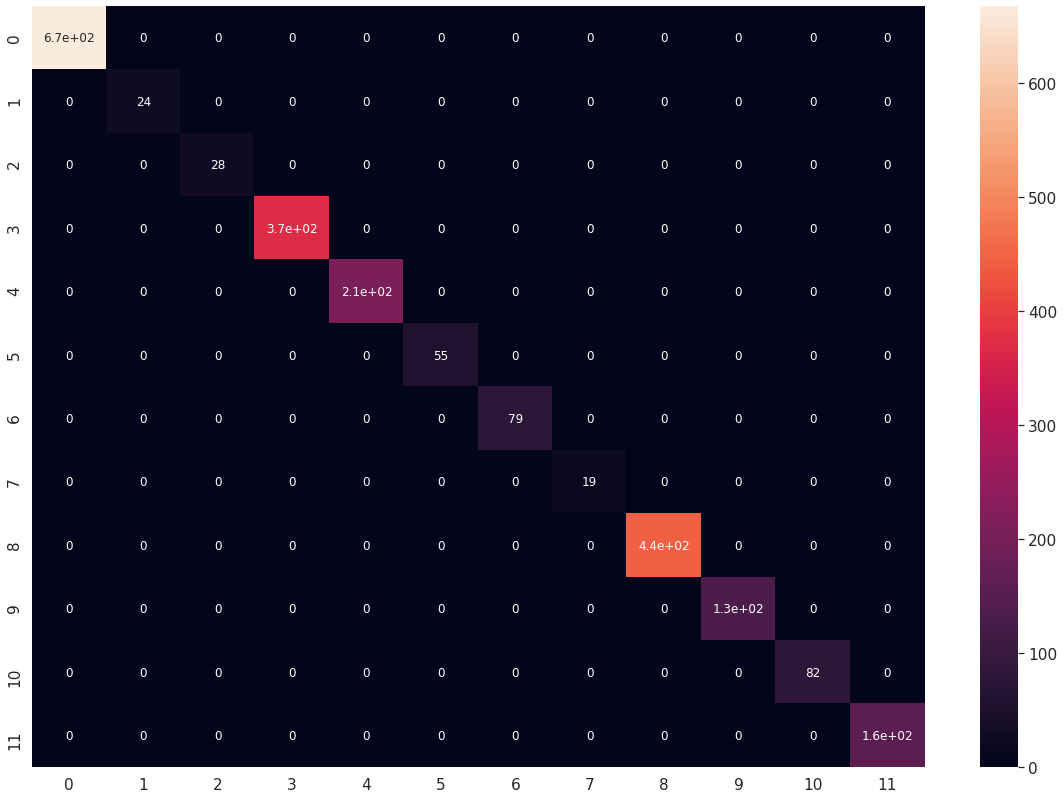

Accuracy: 0.3873239436619718
F1 score: 0.2551668338424143
Recall: 0.3873239436619718
Precision: 0.20883200178571573

 clasification report:
               precision    recall  f1-score   support

           1       0.50      0.86      0.63        88
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           9       0.29      0.97      0.45        34
          12       0.17      0.03      0.05        34
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00        48
          18       0.00      0.00      0.00        15
          19       0.00      0.00      0.00        17
          20       0.00      0.00      0.00        20

    accuracy                           0.39       284
   macro avg       0.08      0.16      0.09       284
weighted avg       0.21      0.39      0.26    

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


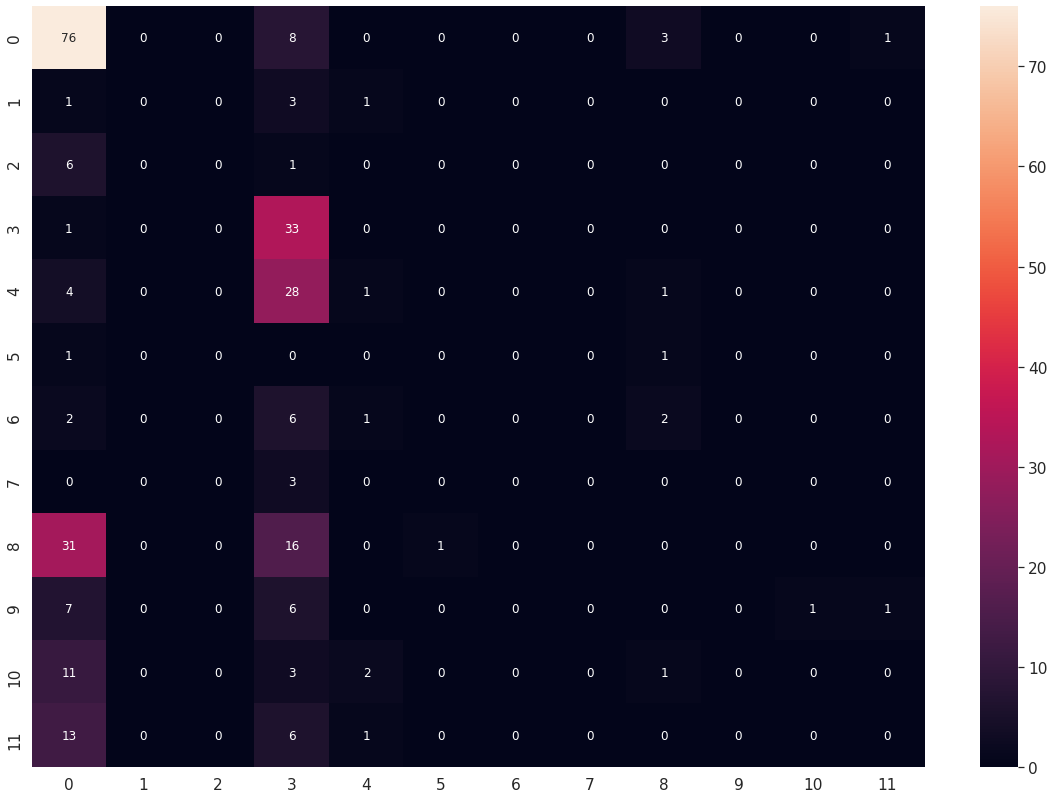

Accuracy: 0.3719298245614035
F1 score: 0.23929383315988326
Recall: 0.3719298245614035
Precision: 0.19946421250547802

 clasification report:
               precision    recall  f1-score   support

           1       0.48      0.89      0.62        79
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           9       0.29      0.90      0.44        39
          12       0.00      0.00      0.00        37
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         5
          17       0.12      0.02      0.03        60
          18       0.00      0.00      0.00        14
          19       0.00      0.00      0.00         8
          20       0.00      0.00      0.00        22

    accuracy                           0.37       285
   macro avg       0.07      0.15      0.09       285
weighted avg       0.20      0.37      0.24   

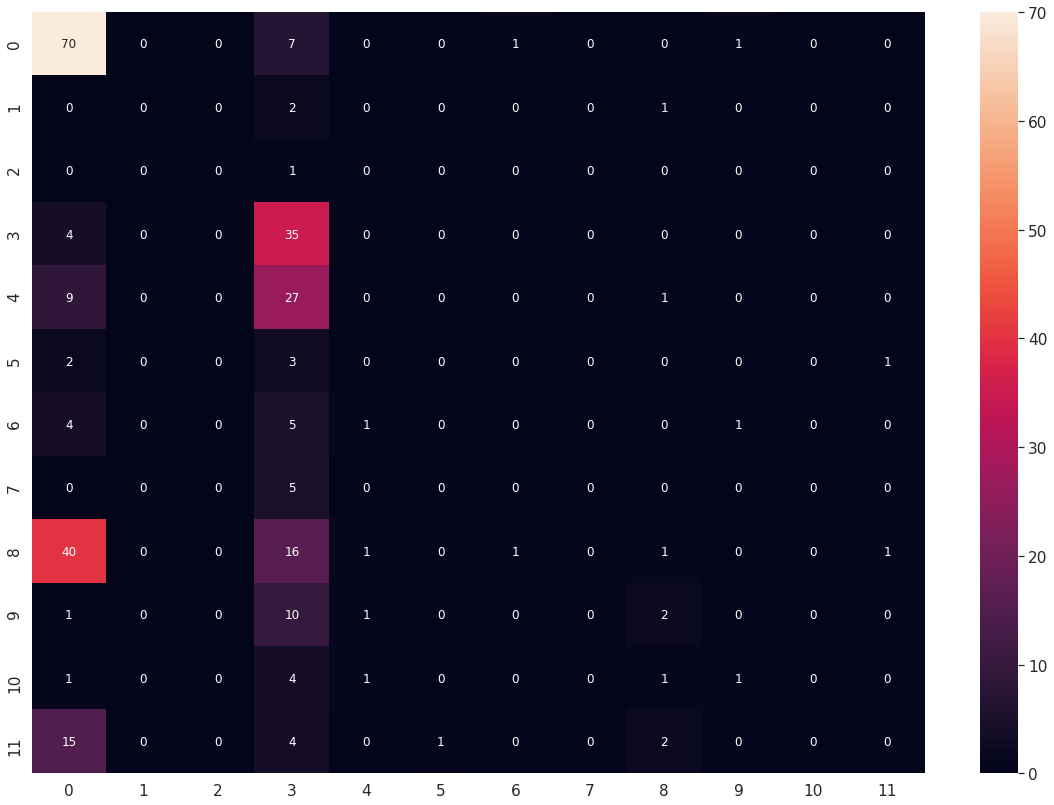

In [14]:
# baseline Nakano et al (2018) architecture 
model = DeepTE(X_trainPCAScaler.shape[1])
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# Using Enthalpy Coding Scheme

In [15]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.enthalpy'
training_data = pd.read_csv(filename)

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values
training_data = None

# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)
feature_vectors= None

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

feature_vectors_scaler = None
X_test_dev = None
Y_test_dev = None

# dimensional reduction with PCA
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

X_dev = None
X_test = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2029, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2027, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 675, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 673, 150)          45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 224, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 225)          101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 74, 225)           0     

18/18 [==============================] - 1s 30ms/step - loss: 0.2805 - f1_m: 0.9027 - val_loss: 4.6057 - val_f1_m: 0.2472
Epoch 47/200
18/18 [==============================] - 1s 29ms/step - loss: 0.2634 - f1_m: 0.9000 - val_loss: 4.9772 - val_f1_m: 0.2425
Epoch 48/200
18/18 [==============================] - 1s 29ms/step - loss: 0.2474 - f1_m: 0.9045 - val_loss: 4.8948 - val_f1_m: 0.2424
Epoch 49/200
18/18 [==============================] - 1s 29ms/step - loss: 0.2494 - f1_m: 0.9045 - val_loss: 5.3407 - val_f1_m: 0.2348
Epoch 50/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2493 - f1_m: 0.9032 - val_loss: 4.6194 - val_f1_m: 0.2345
Epoch 51/200
18/18 [==============================] - 1s 29ms/step - loss: 0.2387 - f1_m: 0.9158 - val_loss: 5.1383 - val_f1_m: 0.2342
Epoch 52/200
18/18 [==============================] - 1s 30ms/step - loss: 0.2596 - f1_m: 0.9047 - val_loss: 4.5290 - val_f1_m: 0.2331
Epoch 53/200
18/18 [==============================] - 1s 29ms/step -

Epoch 107/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1541 - f1_m: 0.9413 - val_loss: 7.4357 - val_f1_m: 0.2478
Epoch 108/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1644 - f1_m: 0.9332 - val_loss: 8.4831 - val_f1_m: 0.2348
Epoch 109/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1545 - f1_m: 0.9415 - val_loss: 7.1776 - val_f1_m: 0.2385
Epoch 110/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1715 - f1_m: 0.9322 - val_loss: 7.2056 - val_f1_m: 0.2468
Epoch 111/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1467 - f1_m: 0.9431 - val_loss: 7.7377 - val_f1_m: 0.2342
Epoch 112/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1573 - f1_m: 0.9449 - val_loss: 6.8988 - val_f1_m: 0.2448
Epoch 113/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1337 - f1_m: 0.9462 - val_loss: 8.3598 - val_f1_m: 0.2507
Epoch 114/200
18/18 [===========================

18/18 [==============================] - 1s 31ms/step - loss: 0.1157 - f1_m: 0.9539 - val_loss: 8.7179 - val_f1_m: 0.2302
Epoch 168/200
18/18 [==============================] - 1s 30ms/step - loss: 0.1153 - f1_m: 0.9596 - val_loss: 9.3235 - val_f1_m: 0.2415
Epoch 169/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1181 - f1_m: 0.9571 - val_loss: 9.1271 - val_f1_m: 0.2313
Epoch 170/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1372 - f1_m: 0.9493 - val_loss: 9.1188 - val_f1_m: 0.2407
Epoch 171/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1276 - f1_m: 0.9544 - val_loss: 8.6701 - val_f1_m: 0.2414
Epoch 172/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1241 - f1_m: 0.9553 - val_loss: 9.3759 - val_f1_m: 0.2324
Epoch 173/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1383 - f1_m: 0.9504 - val_loss: 8.3774 - val_f1_m: 0.2306
Epoch 174/200
18/18 [==============================] - 1s 30ms

Loss=6.6277 and F1-score=0.2325

saved-model-059-0.2489.hdf5
Loss=6.8548 and F1-score=0.2712

saved-model-060-0.2580.hdf5
Loss=6.1090 and F1-score=0.2468

saved-model-061-0.2570.hdf5
Loss=5.9843 and F1-score=0.2177

saved-model-062-0.2471.hdf5
Loss=7.1987 and F1-score=0.2673

saved-model-063-0.2327.hdf5
Loss=7.0485 and F1-score=0.2381

saved-model-064-0.2395.hdf5
Loss=7.3611 and F1-score=0.2489

saved-model-065-0.2424.hdf5
Loss=7.7391 and F1-score=0.2373

saved-model-066-0.2413.hdf5
Loss=6.8142 and F1-score=0.2382

saved-model-067-0.2497.hdf5
Loss=6.5147 and F1-score=0.2598

saved-model-068-0.2454.hdf5
Loss=6.6149 and F1-score=0.2702

saved-model-069-0.2384.hdf5
Loss=7.8619 and F1-score=0.2727

saved-model-070-0.2610.hdf5
Loss=6.7301 and F1-score=0.2326

saved-model-071-0.2387.hdf5
Loss=7.4323 and F1-score=0.2490

saved-model-072-0.2443.hdf5
Loss=7.1987 and F1-score=0.2632

saved-model-073-0.2297.hdf5
Loss=6.7266 and F1-score=0.2610

saved-model-074-0.2349.hdf5
Loss=7.4244 and F1-score

Loss=9.8970 and F1-score=0.2672

saved-model-193-0.2379.hdf5
Loss=9.0692 and F1-score=0.2574

saved-model-194-0.2408.hdf5
Loss=9.9169 and F1-score=0.2577

saved-model-195-0.2443.hdf5
Loss=10.1436 and F1-score=0.2581

saved-model-196-0.2335.hdf5
Loss=9.9314 and F1-score=0.2524

saved-model-197-0.2526.hdf5
Loss=10.6849 and F1-score=0.2370

saved-model-198-0.2417.hdf5
Loss=9.6521 and F1-score=0.2410

saved-model-199-0.2412.hdf5
Loss=10.5997 and F1-score=0.2592

saved-model-200-0.2411.hdf5
Loss=10.4822 and F1-score=0.2662



Best
saved-model-186-0.2271.hdf5
Loss=10.4764 y Accuracy=0.2763



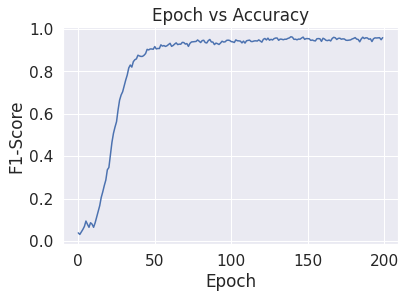

Test F1-Score 0.2763207256793976, Época:186

Test F1-Score 0.27306970953941345, Época:169

Test F1-Score 0.2726999521255493, Época:69

Test F1-Score 0.27221715450286865, Época:135

Test F1-Score 0.27176961302757263, Época:76

Test F1-Score 0.27121150493621826, Época:59

Test F1-Score 0.27032458782196045, Época:91

Test F1-Score 0.27026498317718506, Época:178

Test F1-Score 0.2702226936817169, Época:68

Test F1-Score 0.2701709270477295, Época:43


Train F1-Score 0.9621098637580872, Época:140

Train F1-Score 0.9604463577270508, Época:148

Train F1-Score 0.9599896669387817, Época:187

Train F1-Score 0.9599635601043701, Época:141

Train F1-Score 0.9595663547515869, Época:168

Train F1-Score 0.9581118822097778, Época:182

Train F1-Score 0.9577847719192505, Época:200

Train F1-Score 0.9576215744018555, Época:198

Train F1-Score 0.9572862982749939, Época:189

Train F1-Score 0.9571387767791748, Época:169


Validation F1-Score 0.2793327271938324, Época:43

Validation F1-Score 0.2618262469768524

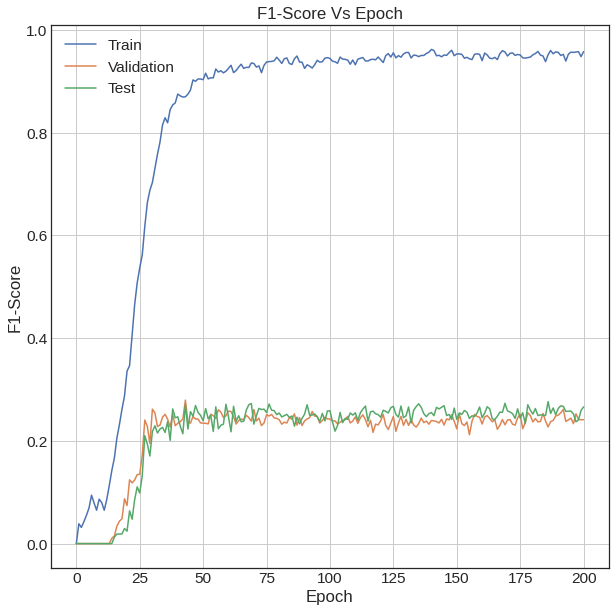

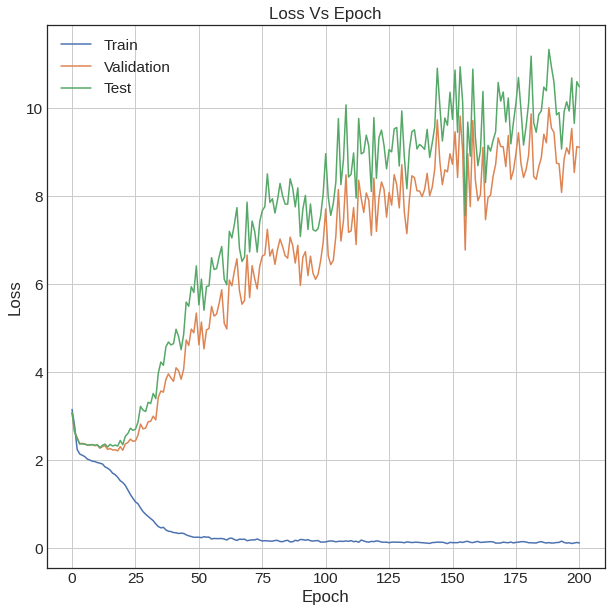

Baseline Error train: 0.04%
Baseline Error dev: 72.79%
Baseline Error test: 73.38%
Accuracy: 0.9995600527936648
F1 score: 0.9995593874788309
Recall: 0.9995600527936648
Precision: 0.9995607113972672

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       667
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        28
           9       1.00      1.00      1.00       372
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00       443
          18       1.00      0.99      1.00       133
          19       1.00      1.00      1.00        82
          20       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       

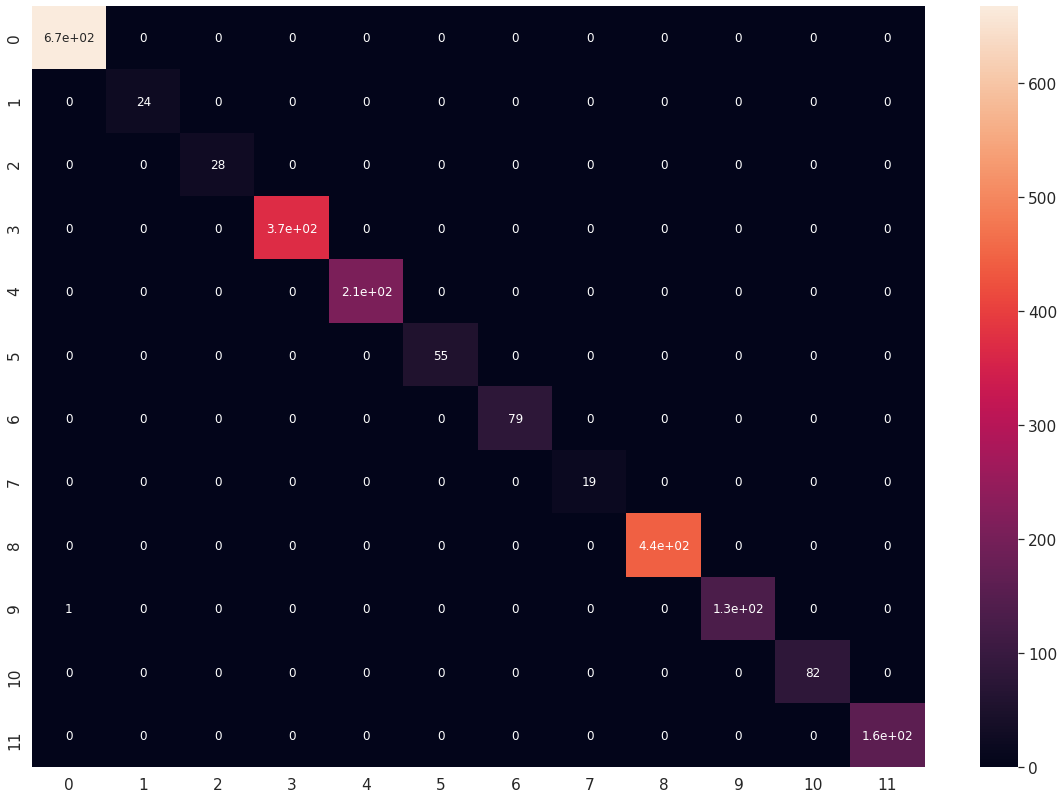

Accuracy: 0.2711267605633803
F1 score: 0.18380274870916088
Recall: 0.2711267605633803
Precision: 0.2025769065173548

 clasification report:
               precision    recall  f1-score   support

           1       0.32      0.77      0.45        88
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           9       0.07      0.09      0.08        34
          12       0.10      0.03      0.05        34
          13       0.00      0.00      0.00         2
          14       0.20      0.09      0.13        11
          16       0.00      0.00      0.00         3
          17       0.44      0.08      0.14        48
          18       0.00      0.00      0.00        15
          19       0.00      0.00      0.00        17
          20       0.00      0.00      0.00        20

    accuracy                           0.27       284
   macro avg       0.09      0.09      0.07       284
weighted avg       0.20      0.27      0.18    

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


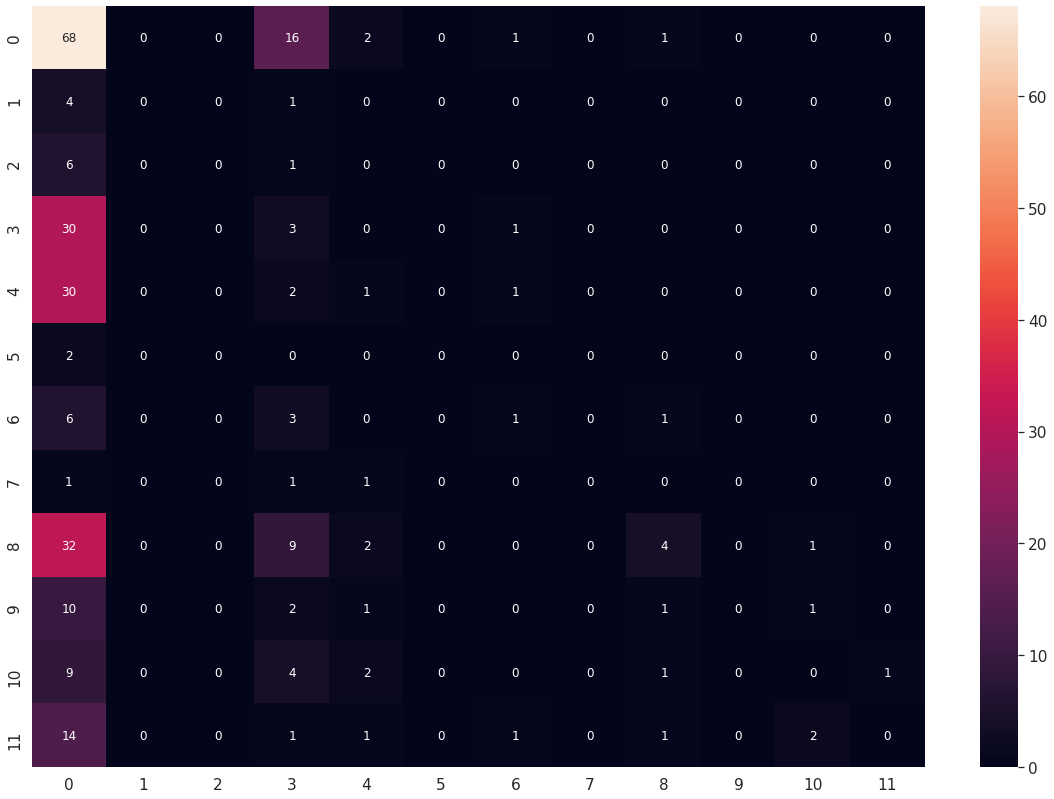

Accuracy: 0.26666666666666666
F1 score: 0.16530558422199293
Recall: 0.26666666666666666
Precision: 0.1337424478731306

 clasification report:
               precision    recall  f1-score   support

           1       0.31      0.81      0.44        79
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           9       0.18      0.23      0.20        39
          12       0.07      0.03      0.04        37
          13       0.00      0.00      0.00         6
          14       0.40      0.18      0.25        11
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00        60
          18       0.00      0.00      0.00        14
          19       0.00      0.00      0.00         8
          20       0.00      0.00      0.00        22

    accuracy                           0.27       285
   macro avg       0.08      0.10      0.08       285
weighted avg       0.13      0.27      0.17  

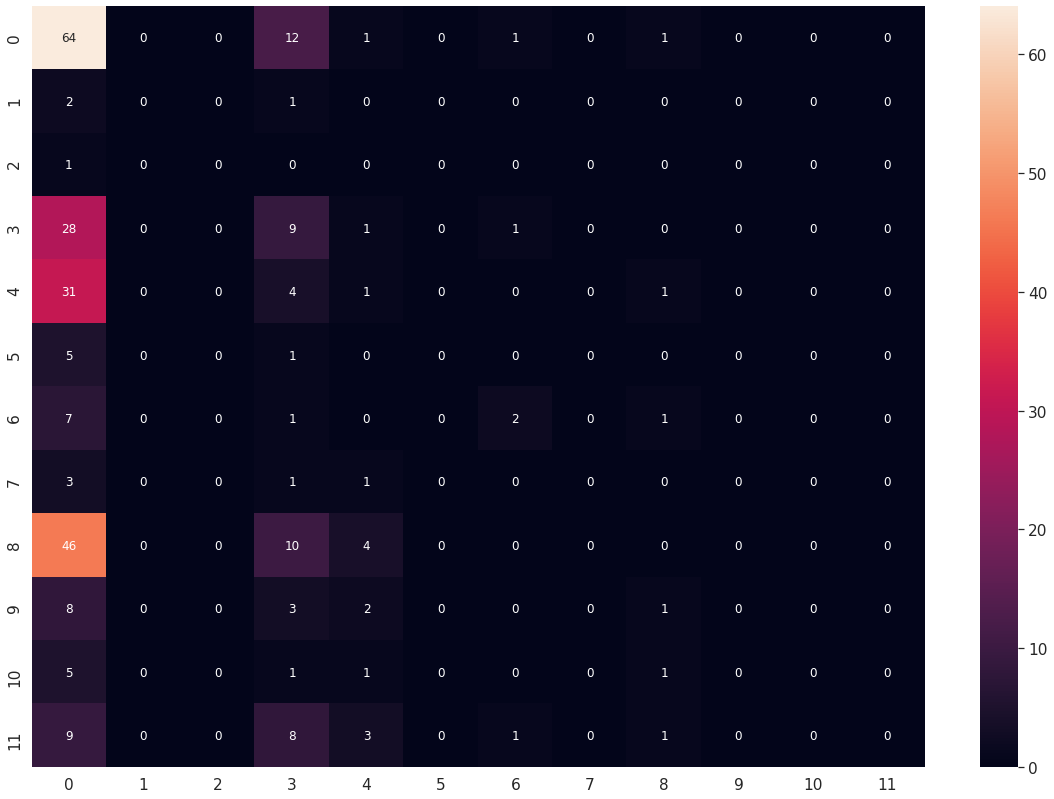

In [16]:
# baseline Nakano et al (2018) architecture 
model = DeepTE(X_trainPCAScaler.shape[1])
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# Using Galois 4 coding scheme

In [23]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.Galois4'
training_data = pd.read_csv(filename)

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values
training_data = None

# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)
feature_vectors= None

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

feature_vectors_scaler = None
X_test_dev = None
Y_test_dev = None

# dimensional reduction with PCA
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

X_dev = None
X_test = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2031, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2029, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 676, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 674, 150)          45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 224, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 225)          101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 74, 225)           0     

Epoch 47/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1785 - f1_m: 0.9331 - val_loss: 5.1719 - val_f1_m: 0.4035
Epoch 48/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1559 - f1_m: 0.9483 - val_loss: 5.8190 - val_f1_m: 0.4202
Epoch 49/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1708 - f1_m: 0.9415 - val_loss: 5.4510 - val_f1_m: 0.4011
Epoch 50/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1848 - f1_m: 0.9355 - val_loss: 5.5177 - val_f1_m: 0.4054
Epoch 51/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1489 - f1_m: 0.9458 - val_loss: 5.6030 - val_f1_m: 0.4327
Epoch 52/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1822 - f1_m: 0.9354 - val_loss: 5.4344 - val_f1_m: 0.4068
Epoch 53/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1518 - f1_m: 0.9426 - val_loss: 5.9194 - val_f1_m: 0.4143
Epoch 54/200
18/18 [==============================] - 1

18/18 [==============================] - 1s 29ms/step - loss: 0.1000 - f1_m: 0.9634 - val_loss: 8.6239 - val_f1_m: 0.4132
Epoch 108/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0969 - f1_m: 0.9661 - val_loss: 9.1405 - val_f1_m: 0.3966
Epoch 109/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0816 - f1_m: 0.9705 - val_loss: 9.0915 - val_f1_m: 0.4174
Epoch 110/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1038 - f1_m: 0.9600 - val_loss: 9.1500 - val_f1_m: 0.4116
Epoch 111/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0984 - f1_m: 0.9664 - val_loss: 8.9748 - val_f1_m: 0.4132
Epoch 112/200
18/18 [==============================] - 1s 30ms/step - loss: 0.0988 - f1_m: 0.9619 - val_loss: 9.2982 - val_f1_m: 0.3966
Epoch 113/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0919 - f1_m: 0.9641 - val_loss: 8.5120 - val_f1_m: 0.3976
Epoch 114/200
18/18 [==============================] - 1s 29ms

18/18 [==============================] - 1s 29ms/step - loss: 0.0905 - f1_m: 0.9677 - val_loss: 10.4206 - val_f1_m: 0.4138
Epoch 168/200
18/18 [==============================] - 1s 30ms/step - loss: 0.0869 - f1_m: 0.9690 - val_loss: 10.4292 - val_f1_m: 0.4040
Epoch 169/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0707 - f1_m: 0.9738 - val_loss: 11.7127 - val_f1_m: 0.4071
Epoch 170/200
18/18 [==============================] - 1s 30ms/step - loss: 0.0707 - f1_m: 0.9719 - val_loss: 10.5408 - val_f1_m: 0.4169
Epoch 171/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0909 - f1_m: 0.9700 - val_loss: 10.7882 - val_f1_m: 0.4111
Epoch 172/200
18/18 [==============================] - 1s 29ms/step - loss: 0.1036 - f1_m: 0.9620 - val_loss: 11.3605 - val_f1_m: 0.4143
Epoch 173/200
18/18 [==============================] - 1s 29ms/step - loss: 0.0934 - f1_m: 0.9655 - val_loss: 11.4634 - val_f1_m: 0.4315
Epoch 174/200
18/18 [==============================] - 

Loss=7.2602 and F1-score=0.3976

saved-model-059-0.4143.hdf5
Loss=7.8921 and F1-score=0.3921

saved-model-060-0.4138.hdf5
Loss=8.5380 and F1-score=0.3957

saved-model-061-0.4111.hdf5
Loss=7.6449 and F1-score=0.3975

saved-model-062-0.4027.hdf5
Loss=8.0194 and F1-score=0.4014

saved-model-063-0.4101.hdf5
Loss=8.0666 and F1-score=0.3986

saved-model-064-0.4143.hdf5
Loss=7.9728 and F1-score=0.3917

saved-model-065-0.4122.hdf5
Loss=7.9198 and F1-score=0.3953

saved-model-066-0.4081.hdf5
Loss=7.4895 and F1-score=0.3978

saved-model-067-0.4106.hdf5
Loss=8.4623 and F1-score=0.3930

saved-model-068-0.3984.hdf5
Loss=7.9091 and F1-score=0.3871

saved-model-069-0.4063.hdf5
Loss=7.9913 and F1-score=0.3983

saved-model-070-0.4011.hdf5
Loss=8.1375 and F1-score=0.3923

saved-model-071-0.3998.hdf5
Loss=8.4931 and F1-score=0.3929

saved-model-072-0.4122.hdf5
Loss=8.5549 and F1-score=0.3918

saved-model-073-0.4095.hdf5
Loss=8.4254 and F1-score=0.3937

saved-model-074-0.3987.hdf5
Loss=8.5853 and F1-score

Loss=14.0245 and F1-score=0.3980

saved-model-192-0.4230.hdf5
Loss=13.3461 and F1-score=0.4055

saved-model-193-0.3783.hdf5
Loss=12.9314 and F1-score=0.4034

saved-model-194-0.4028.hdf5
Loss=12.9729 and F1-score=0.4014

saved-model-195-0.4133.hdf5
Loss=12.8302 and F1-score=0.4000

saved-model-196-0.4225.hdf5
Loss=13.8089 and F1-score=0.3911

saved-model-197-0.3984.hdf5
Loss=13.4328 and F1-score=0.3971

saved-model-198-0.4204.hdf5
Loss=12.8388 and F1-score=0.3914

saved-model-199-0.4041.hdf5
Loss=12.4578 and F1-score=0.3971

saved-model-200-0.4161.hdf5
Loss=13.6742 and F1-score=0.3863



Best
saved-model-038-0.4085.hdf5
Loss=5.0744 y Accuracy=0.4081



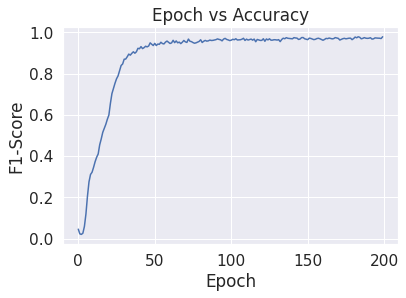

Test F1-Score 0.4081462621688843, Época:38

Test F1-Score 0.40767014026641846, Época:28

Test F1-Score 0.4065266251564026, Época:33

Test F1-Score 0.4062071442604065, Época:31

Test F1-Score 0.40586960315704346, Época:158

Test F1-Score 0.4056921899318695, Época:32

Test F1-Score 0.40551599860191345, Época:192

Test F1-Score 0.4054250717163086, Época:161

Test F1-Score 0.4053163230419159, Época:155

Test F1-Score 0.40510526299476624, Época:163


Train F1-Score 0.9779630303382874, Época:200

Train F1-Score 0.9778788685798645, Época:184

Train F1-Score 0.9765370488166809, Época:182

Train F1-Score 0.9752150774002075, Época:185

Train F1-Score 0.9741407036781311, Época:148

Train F1-Score 0.9738378524780273, Época:147

Train F1-Score 0.9738191962242126, Época:169

Train F1-Score 0.9736931324005127, Época:188

Train F1-Score 0.9735817313194275, Época:142

Train F1-Score 0.9735578894615173, Época:137


Validation F1-Score 0.4350356161594391, Época:176

Validation F1-Score 0.4326610267162323

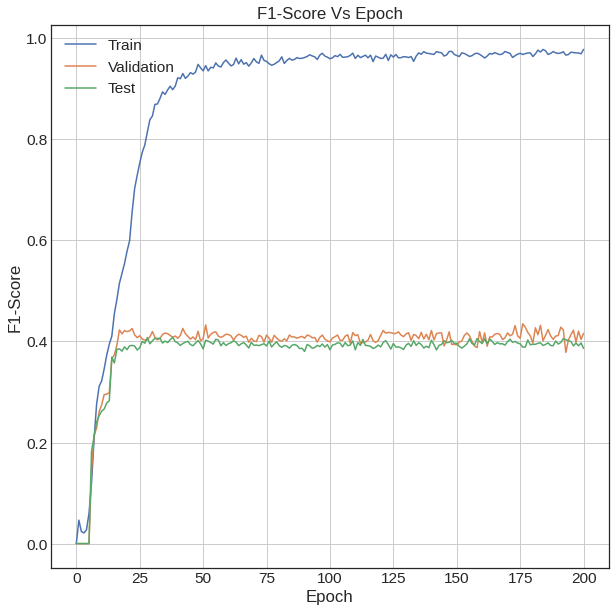

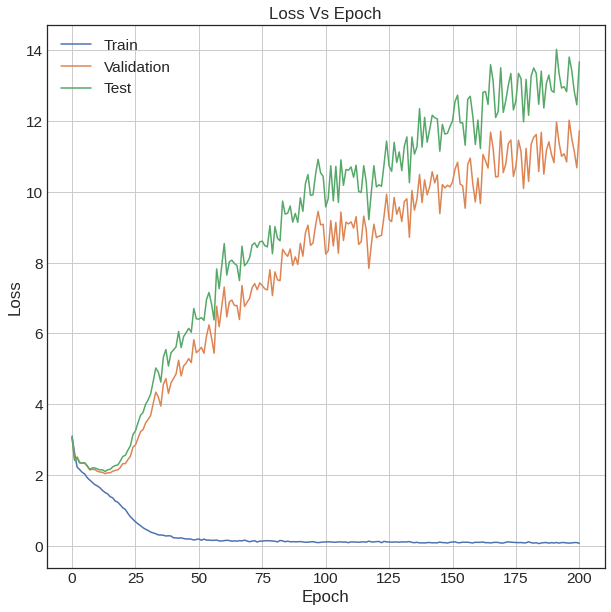

Baseline Error train: 0.00%
Baseline Error dev: 60.02%
Baseline Error test: 61.37%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       667
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        28
           9       1.00      1.00      1.00       372
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00       443
          18       1.00      1.00      1.00       133
          19       1.00      1.00      1.00        82
          20       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00  

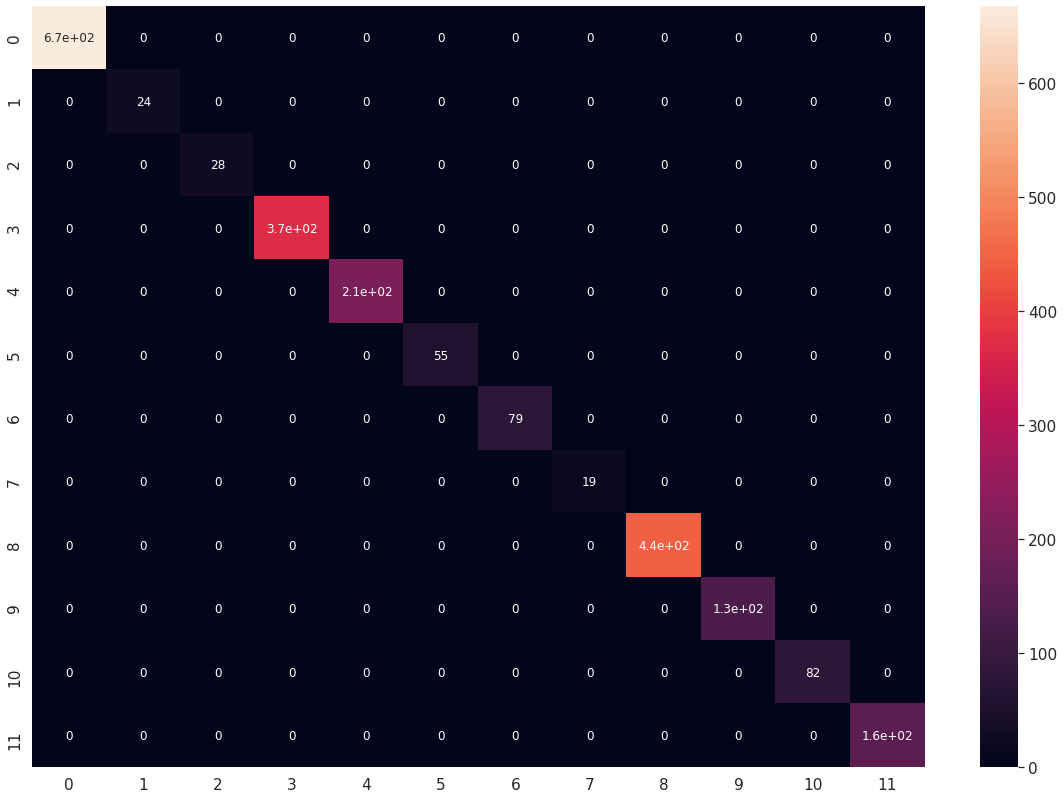

Accuracy: 0.40492957746478875
F1 score: 0.2764445792244161
Recall: 0.40492957746478875
Precision: 0.27356908748086

 clasification report:
               precision    recall  f1-score   support

           1       0.49      0.89      0.63        88
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           9       0.31      0.94      0.47        34
          12       0.14      0.09      0.11        34
          13       1.00      0.50      0.67         2
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00        48
          18       0.00      0.00      0.00        15
          19       1.00      0.06      0.11        17
          20       0.00      0.00      0.00        20

    accuracy                           0.40       284
   macro avg       0.25      0.21      0.17       284
weighted avg       0.27      0.40      0.28     

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


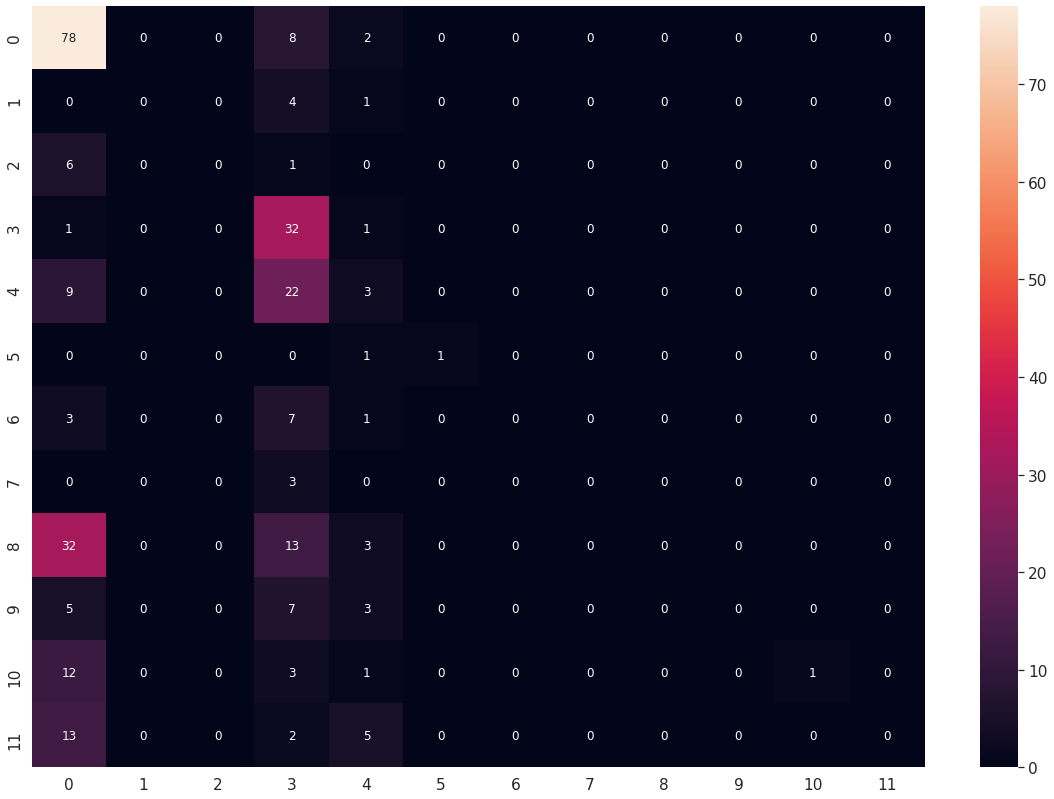

Accuracy: 0.37894736842105264
F1 score: 0.2552794821858143
Recall: 0.37894736842105264
Precision: 0.3038658967986823

 clasification report:
               precision    recall  f1-score   support

           1       0.44      0.85      0.58        79
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           9       0.33      0.90      0.48        39
          12       0.25      0.14      0.18        37
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         5
          17       0.50      0.02      0.03        60
          18       0.00      0.00      0.00        14
          19       0.00      0.00      0.00         8
          20       0.00      0.00      0.00        22

    accuracy                           0.38       285
   macro avg       0.13      0.16      0.11       285
weighted avg       0.30      0.38      0.26   

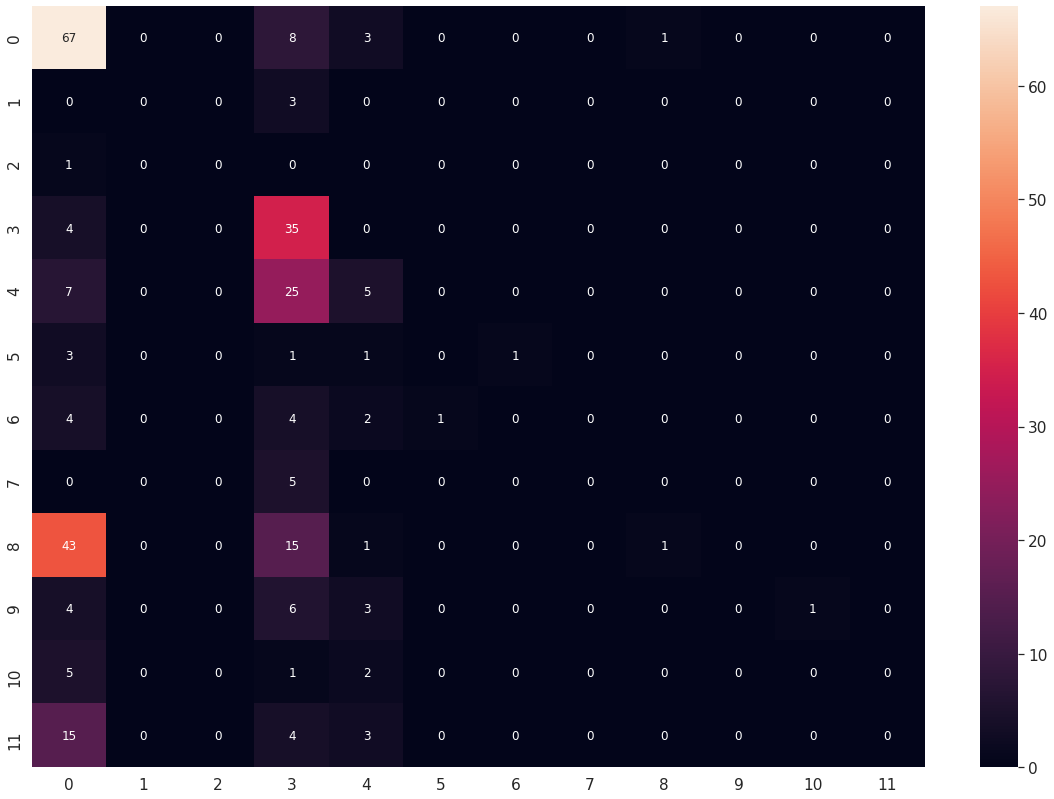

In [24]:
# baseline Nakano et al (2018) architecture 
model = DeepTE(X_trainPCAScaler.shape[1])
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# Using K-mers 

In [19]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.kmers'
training_data = pd.read_csv(filename)

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values
training_data = None

# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)
feature_vectors= None

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

feature_vectors_scaler = None
X_test_dev = None
Y_test_dev = None

# dimensional reduction with PCA
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

X_dev = None
X_test = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1254, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1252, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 417, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 415, 150)          45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 138, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 136, 225)          101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 225)           0     

Epoch 47/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0468 - f1_m: 0.9866 - val_loss: 1.7645 - val_f1_m: 0.7473
Epoch 48/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0400 - f1_m: 0.9862 - val_loss: 1.7820 - val_f1_m: 0.7368
Epoch 49/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0442 - f1_m: 0.9839 - val_loss: 1.4374 - val_f1_m: 0.7645
Epoch 50/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0547 - f1_m: 0.9807 - val_loss: 1.5308 - val_f1_m: 0.7628
Epoch 51/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0394 - f1_m: 0.9870 - val_loss: 1.7540 - val_f1_m: 0.7397
Epoch 52/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0375 - f1_m: 0.9857 - val_loss: 1.9973 - val_f1_m: 0.7376
Epoch 53/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0395 - f1_m: 0.9856 - val_loss: 1.6883 - val_f1_m: 0.7769
Epoch 54/200
18/18 [==============================] - 0

18/18 [==============================] - 0s 20ms/step - loss: 0.0230 - f1_m: 0.9908 - val_loss: 1.8641 - val_f1_m: 0.7781
Epoch 108/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0210 - f1_m: 0.9911 - val_loss: 2.0160 - val_f1_m: 0.7806
Epoch 109/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0243 - f1_m: 0.9914 - val_loss: 1.4195 - val_f1_m: 0.8026
Epoch 110/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0230 - f1_m: 0.9928 - val_loss: 2.0309 - val_f1_m: 0.7576
Epoch 111/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0316 - f1_m: 0.9897 - val_loss: 2.0196 - val_f1_m: 0.7531
Epoch 112/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0281 - f1_m: 0.9911 - val_loss: 1.4471 - val_f1_m: 0.8068
Epoch 113/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0194 - f1_m: 0.9942 - val_loss: 1.5202 - val_f1_m: 0.8073
Epoch 114/200
18/18 [==============================] - 0s 20ms

18/18 [==============================] - 0s 20ms/step - loss: 0.0213 - f1_m: 0.9915 - val_loss: 1.6411 - val_f1_m: 0.8000
Epoch 168/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0283 - f1_m: 0.9908 - val_loss: 2.1814 - val_f1_m: 0.8051
Epoch 169/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0283 - f1_m: 0.9902 - val_loss: 1.2961 - val_f1_m: 0.8468
Epoch 170/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0188 - f1_m: 0.9935 - val_loss: 1.3319 - val_f1_m: 0.8316
Epoch 171/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0165 - f1_m: 0.9945 - val_loss: 1.9633 - val_f1_m: 0.8082
Epoch 172/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0345 - f1_m: 0.9881 - val_loss: 1.4377 - val_f1_m: 0.8030
Epoch 173/200
18/18 [==============================] - 0s 20ms/step - loss: 0.0291 - f1_m: 0.9890 - val_loss: 1.5931 - val_f1_m: 0.8159
Epoch 174/200
18/18 [==============================] - 0s 21ms

Loss=0.7232 and F1-score=0.8590

saved-model-059-0.8038.hdf5
Loss=1.1954 and F1-score=0.8171

saved-model-060-0.7530.hdf5
Loss=1.5343 and F1-score=0.7995

saved-model-061-0.7700.hdf5
Loss=1.0557 and F1-score=0.8389

saved-model-062-0.7500.hdf5
Loss=1.3235 and F1-score=0.8135

saved-model-063-0.7385.hdf5
Loss=1.4855 and F1-score=0.7963

saved-model-064-0.8049.hdf5
Loss=1.0434 and F1-score=0.8417

saved-model-065-0.7460.hdf5
Loss=1.3272 and F1-score=0.8251

saved-model-066-0.7662.hdf5
Loss=1.2535 and F1-score=0.8290

saved-model-067-0.7498.hdf5
Loss=1.3645 and F1-score=0.8093

saved-model-068-0.7743.hdf5
Loss=1.2344 and F1-score=0.8233

saved-model-069-0.7509.hdf5
Loss=1.1530 and F1-score=0.8291

saved-model-070-0.7266.hdf5
Loss=1.5865 and F1-score=0.7957

saved-model-071-0.7141.hdf5
Loss=1.7191 and F1-score=0.7835

saved-model-072-0.7531.hdf5
Loss=1.2385 and F1-score=0.8208

saved-model-073-0.7987.hdf5
Loss=1.2091 and F1-score=0.8309

saved-model-074-0.8075.hdf5
Loss=0.9297 and F1-score

Loss=1.4036 and F1-score=0.8520

saved-model-194-0.7796.hdf5
Loss=0.9886 and F1-score=0.8649

saved-model-195-0.7875.hdf5
Loss=1.2198 and F1-score=0.8616

saved-model-196-0.7869.hdf5
Loss=1.3828 and F1-score=0.8380

saved-model-197-0.8321.hdf5
Loss=1.1161 and F1-score=0.8648

saved-model-198-0.8161.hdf5
Loss=1.1873 and F1-score=0.8558

saved-model-199-0.8113.hdf5
Loss=1.4113 and F1-score=0.8517

saved-model-200-0.8087.hdf5
Loss=0.9460 and F1-score=0.8671



Best
saved-model-176-0.8493.hdf5
Loss=0.9287 y Accuracy=0.8870



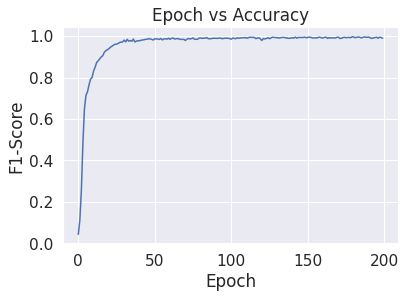

Test F1-Score 0.8869756460189819, Época:176

Test F1-Score 0.8856351971626282, Época:172

Test F1-Score 0.8835939764976501, Época:179

Test F1-Score 0.8800827860832214, Época:173

Test F1-Score 0.8793809413909912, Época:189

Test F1-Score 0.8789377808570862, Época:185

Test F1-Score 0.8773945569992065, Época:170

Test F1-Score 0.8750512599945068, Época:130

Test F1-Score 0.8746708631515503, Época:116

Test F1-Score 0.8735365271568298, Época:155


Train F1-Score 0.99652099609375, Época:180

Train F1-Score 0.9955193400382996, Época:181

Train F1-Score 0.9954401850700378, Época:188

Train F1-Score 0.9953014850616455, Época:184

Train F1-Score 0.9952223300933838, Época:191

Train F1-Score 0.9948554635047913, Época:143

Train F1-Score 0.9947893619537354, Época:149

Train F1-Score 0.994706392288208, Época:128

Train F1-Score 0.9946427941322327, Época:198

Train F1-Score 0.9945704340934753, Época:163


Validation F1-Score 0.8496688008308411, Época:157

Validation F1-Score 0.8492922186851501, 

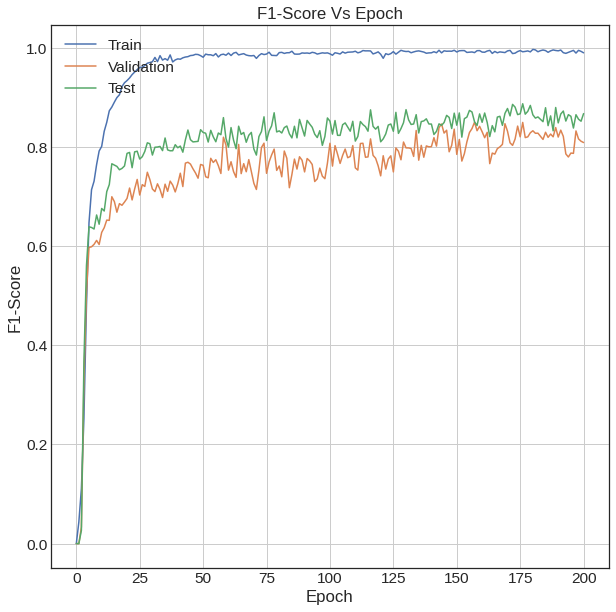

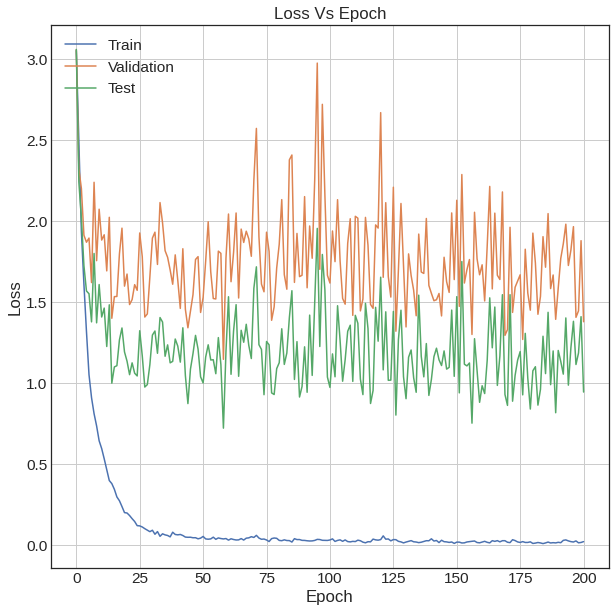

Baseline Error train: 0.00%
Baseline Error dev: 19.55%
Baseline Error test: 13.29%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       667
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        28
           9       1.00      1.00      1.00       372
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00       443
          18       1.00      1.00      1.00       133
          19       1.00      1.00      1.00        82
          20       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00  

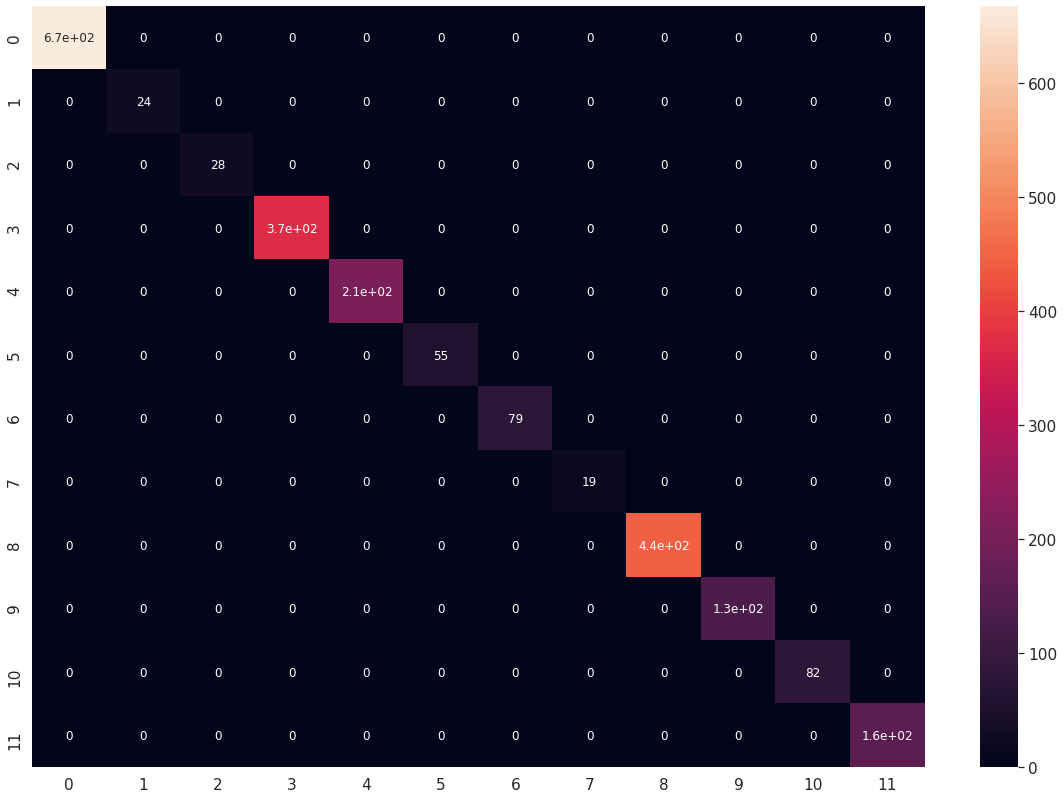

Accuracy: 0.8063380281690141
F1 score: 0.7959555048150534
Recall: 0.8063380281690141
Precision: 0.8176532385610383

 clasification report:
               precision    recall  f1-score   support

           1       0.85      0.94      0.89        88
           3       1.00      0.40      0.57         5
           4       1.00      0.43      0.60         7
           9       0.75      0.88      0.81        34
          12       0.58      0.56      0.57        34
          13       1.00      1.00      1.00         2
          14       0.83      0.45      0.59        11
          16       1.00      0.33      0.50         3
          17       0.88      0.94      0.91        48
          18       0.82      0.60      0.69        15
          19       1.00      0.59      0.74        17
          20       0.74      1.00      0.85        20

    accuracy                           0.81       284
   macro avg       0.87      0.68      0.73       284
weighted avg       0.82      0.81      0.80     

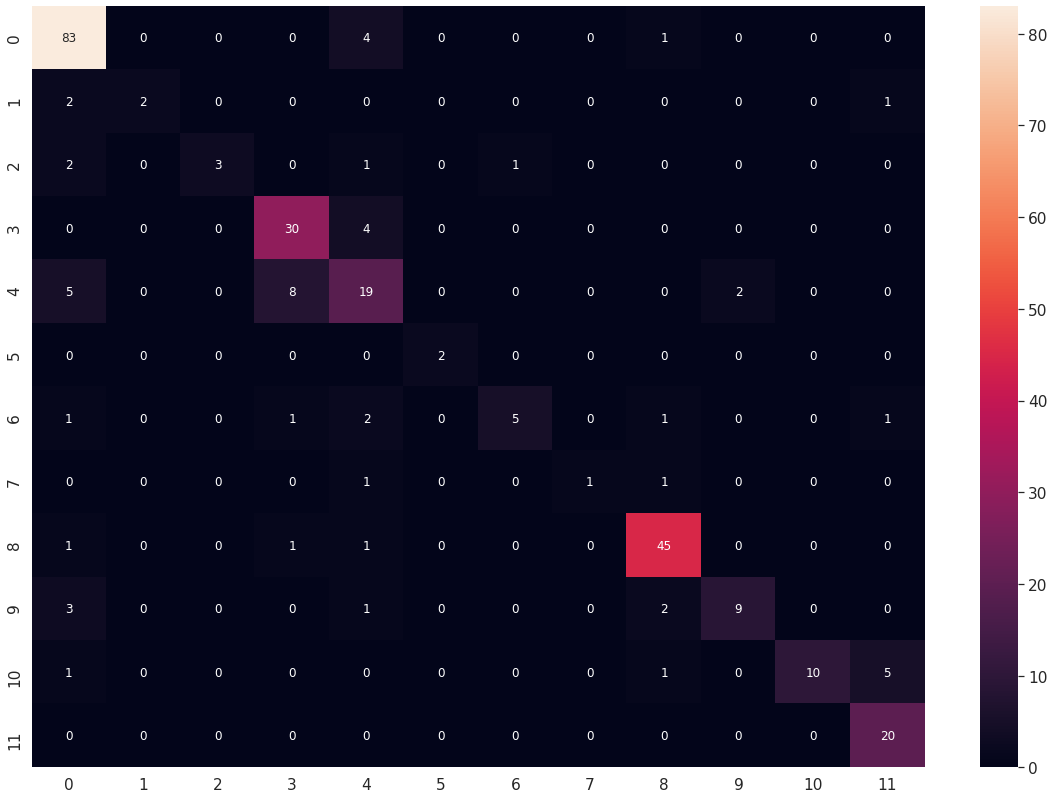

Accuracy: 0.8631578947368421
F1 score: 0.8496535704317022
Recall: 0.8631578947368421
Precision: 0.8609075899837377

 clasification report:
               precision    recall  f1-score   support

           1       0.93      0.94      0.93        79
           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         1
           9       0.81      0.97      0.88        39
          12       0.83      0.68      0.75        37
          13       1.00      0.83      0.91         6
          14       0.67      0.73      0.70        11
          16       1.00      0.20      0.33         5
          17       0.89      0.98      0.94        60
          18       0.79      0.79      0.79        14
          19       0.67      0.25      0.36         8
          20       0.85      1.00      0.92        22

    accuracy                           0.86       285
   macro avg       0.79      0.64      0.67       285
weighted avg       0.86      0.86      0.85     

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


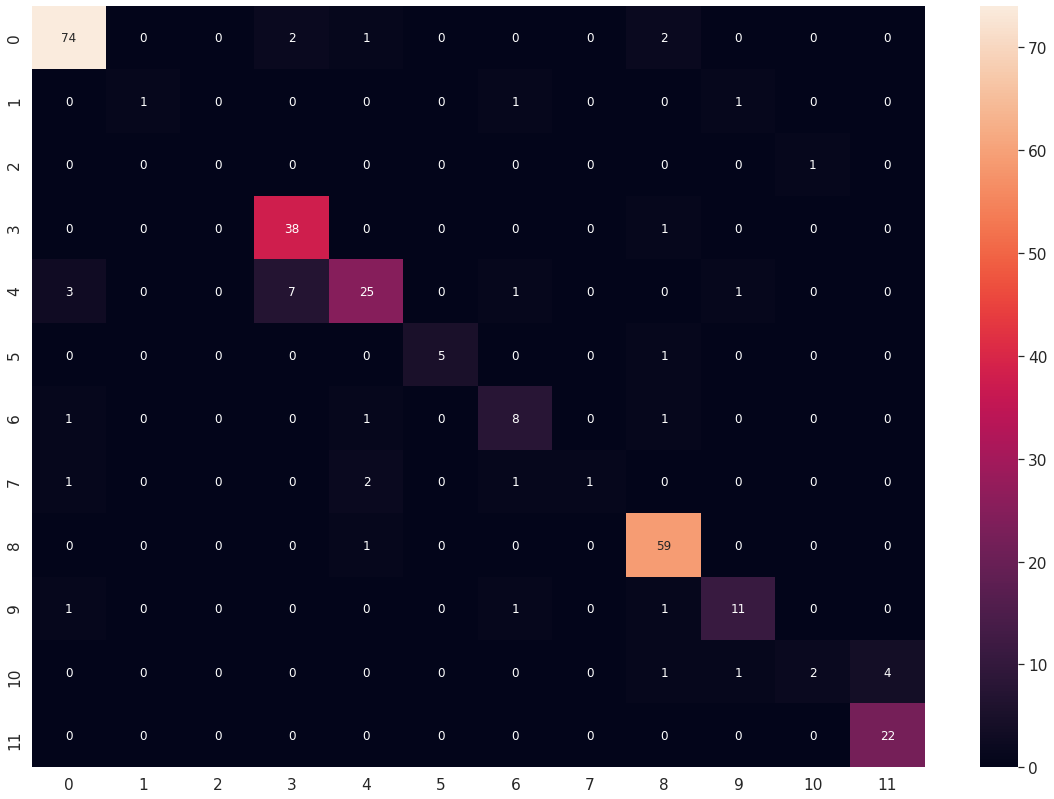

In [20]:
# baseline Nakano et al (2018) architecture 
model = DeepTE(X_trainPCAScaler.shape[1])
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])